**Time course of alterations in adult spinal motoneuron properties in the G93A mouse model of ALS**

Seoan Huh (1), Charles J. Heckman (1,2,3), and Marin Manuel (1,4)§

1 Department of Physiology, 
2 Department of Physical Medicine and Rehabilitation, and 
3 Department of Physical Therapy and Human Movement Science, Northwestern University, Feinberg School of Medicine, Chicago, Illinois, USA. 
4 Université de Paris, SPPIN - Saints-Pères Paris Institute for the Neurosciences, CNRS, Paris, France.

§ Corresponding author:
Marin MANUEL
email: &lt;firstname&gt; _dot_ &lt;lastname&gt; _at_ neurobio.org

This notebook provides all the data analysis and the code to reproduce the figures of the paper

Imports...

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker
import numpy as np
import seaborn as sns
import pandas as pd
import dabest
import scipy
from scipy import stats as st
import statsmodels
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, Markdown as md
from io import StringIO
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Versions of the libraries

In [2]:
used_libs = [matplotlib, np, sns, pd, dabest, scipy, statsmodels, sklearn]
for lib in used_libs:
    print(lib.__name__,lib.__version__)

matplotlib 3.3.1
numpy 1.19.2
seaborn 0.11.0
pandas 1.0.5
dabest 0.3.0
scipy 1.5.2
statsmodels 0.12.0
sklearn 0.23.2


Some helpful functions and classes

In [3]:
# from https://docs.python.org/3/library/itertools.html#itertools-recipes
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [4]:
def compare_WT_SOD(data,units,precision='.2f'):
    out=f'{{:{precision}}}±{{:{precision}}}{units}, N={{:d}}'
    es_out=f'*g*={{:.2f}} 95%CI[{{:.2f}}–{{:.2f}}]'
    wt = data.iloc[:,0].dropna()
    sod = data.iloc[:,1].dropna()
    t,p = st.ttest_ind(wt,sod, equal_var=False)
    d = dabest.load(data,idx=data.columns.values).hedges_g
    out = f'{data.columns[0]}: {out.format(np.mean(wt),np.std(wt, ddof=1), len(wt))} vs. '\
    f'{data.columns[1]}: {out.format(np.mean(sod),np.std(sod, ddof=1), len(sod))}; '\
    f'{es_out.format(d.results["difference"][0],d.results["bca_low"][0],d.results["bca_high"][0])}; '\
    f'*t*({len(wt)+len(sod)-2:d})={t:.2f}, *p*={p:.2g}'
    out = out.replace('-','−') #replace hyphens by minus signs
    return out
    

In [5]:
def print_slope_stats(res, param, units='', precision='.2g'):
    val = res.params[param]
    CI = res.conf_int().loc[param].values
    p = res.pvalues[param]
    r = res.rsquared
    units = f' {units}' if len(units)>0 else ''
    out = f'slope={{:{precision}}}{units} 95%CI[{{:{precision}}}–{{:{precision}}}], r^2={{:{precision}}} (p={{:{precision}}})'
    out = out.format(val,*CI,r,p)
    out = out.replace('-','−')
    return out

In [6]:
# from https://matplotlib.org/3.1.1/gallery/misc/anchored_artists.html
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker, HPacker)

class HSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), size, 0, ec="black", lw=plt.rcParams['axes.linewidth']))

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = VPacker(children=[self.size_bar, self.txt_label],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)
        

class VSizeBar(AnchoredOffsetbox):
    def __init__(self, transform, size, label, loc,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, frameon=True, textprops=None, **kwargs):
        """
        Draw a horizontal bar with the size in data coordinate of the given
        axes. A label will be drawn underneath (center-aligned).

        pad, borderpad in fraction of the legend font size (or prop)
        sep in points.
        """
        self.size_bar = AuxTransformBox(transform)
        self.size_bar.add_artist(Rectangle((0, 0), 0, size, ec="black", lw=plt.rcParams['axes.linewidth']))
        
        textprops = textprops or {}
        if 'rotation' not in textprops:
            textprops['rotation'] = 90

        self.txt_label = TextArea(label, minimumdescent=False, textprops=textprops)

        self._box = HPacker(children=[self.txt_label, self.size_bar],
                            align="center",
                            pad=0, sep=sep)

        super().__init__(loc, pad=pad, borderpad=borderpad,
                         child=self._box, prop=prop, frameon=frameon, **kwargs)

In [7]:
def stars(p):
    if p < 0.0001:
        return "✻✻✻✻"
    elif (p < 0.001):
        return "✻✻✻"
    elif (p < 0.01):
        return "✻✻"
    elif (p < 0.05):
        return "✻"
    else:
        return "NS"

    
def draw_stars(x, y, text, ax=None, height=0.05, lw=2, c='grey', text_offset=0, fontsize=12):
    if ax is None:
        ax = plt.gca()
    
    if len(x)!=2:
        raise ValueError('x must have two elements')
        
    old_xlim = ax.get_xlim()
    old_ylim = ax.get_ylim()

    #get the coordinates of points (x[0],y) and (x[1],y) in `Axes` coordinates
    x1ax,yax = ax.transLimits.transform(ax.transScale.transform([x[0],y]))
    x2ax,yax = ax.transLimits.transform(ax.transScale.transform([x[1],y]))

    # calculate the coordinates of the line to trace (in Axes coordinates)
    _x = [x1ax, x1ax, x2ax, x2ax]
    _y = [yax, yax+height, yax+height, yax]
    #print (_x,_y)
    ax.plot(_x, _y, transform=ax.transAxes, c=c, lw=lw, clip_on=False)
    #_off = np.diff(ax.transAxes.transform([[0,0],[0,height+text_offset]]), axis=0)
    #y_off = _off[0,1]
    #print(y_off)
    #ax.annotate(text, xy=(np.mean(x),y), xytext=(0,y_off), textcoords='offset pixels', ha='center', va='bottom', fontsize=fontsize, annotation_clip=False, fontname='DejaVu Sans')
    from matplotlib.transforms import blended_transform_factory
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(x=np.mean(x), y=yax+height+text_offset, s=text,
           ha='center', va='bottom', fontsize=fontsize, fontname='DejaVu Sans',
           transform=trans)
    
    # restore view limits
    ax.set_xlim(old_xlim)
    ax.set_ylim(old_ylim)

# Load the data

Data is provided as a .csv file

In [8]:
data = pd.read_csv('./DATA_PIC_Huh_et_al_2020.csv', index_col=0)

In [9]:
data

,ExpDate,Nerve,MouseAge,MouseWeight,MouseSex,Genotype,NbTransgenes,AgeGroup,G+A,PIC Amp,...,∆F,Gain_Asc,Vth,Gain_Desc,I_SPR-PR,F_SPR-PR,RMP,∆Vth,∆V_PIC onset,∆V_PIC peak
cell,,,,,,,,,,,,,,,,,,,,,
128,20140117,sciatic,71,26,M,WT,0.0,P60–90,WT_P60–90,2.1,...,2.400000,9.226122,-48.000000,12.192781,3.300000,41.740000,-60.73,12.730000,-2.27,14.23
130,20140117,sciatic,71,26,M,WT,0.0,P60–90,WT_P60–90,1.9,...,11.500000,28.222264,-52.700000,14.973606,4.400000,41.490000,-69.24,16.540000,-1.46,24.14
141,20140129,Tibial,72,19,M,SOD1,NaN,P60–90,SOD1_P60–90,0.6,...,7.528744,31.251048,-50.674438,40.733966,1.252689,38.064441,-58.30,7.625562,10.10,13.00
143,20140129,EPSP_Tibial,72,19,M,SOD1,NaN,P60–90,SOD1_P60–90,3.3,...,-8.200000,11.065908,-38.500000,4.790233,4.500000,28.300000,-62.50,24.000000,10.70,26.70
147,20140206,tibial,90,17,M,WT,0.0,P60–90,WT_P60–90,3.4,...,56.000000,6.723550,-36.400000,112.635632,5.300000,67.300000,-52.53,16.130000,-8.87,19.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,20160523,sciatic,98,31,M,WT,0.0,P90–120,WT_P90–120,13.4,...,-1.300000,5.600000,-39.400000,21.000000,9.800000,55.900000,-62.10,22.700000,-0.10,27.80
1091,20160523,sciatic,98,31,M,WT,0.0,P90–120,WT_P90–120,2.6,...,0.300000,8.600000,-51.600000,13.100000,2.400000,41.600000,-66.10,14.500000,0.00,10.30
1100,20160526,sciatic,103,26,M,WT,0.0,P90–120,WT_P90–120,7.8,...,-14.700000,6.350000,-47.800000,12.820000,7.700000,72.000000,-74.30,26.500000,6.50,30.90


In [10]:
data.columns

Index(['ExpDate', 'Nerve', 'MouseAge', 'MouseWeight', 'MouseSex', 'Genotype',
       'NbTransgenes', 'AgeGroup', 'G+A', 'PIC Amp', 'PIC/Gin', 'V_PIC onset',
       'V_PIC peak', 'PICdown Amp', 'PICdown/Gin', 'V_PIC offset',
       'V_PICdown peak', 'Gin', 'RepFiring', 'Ion', 'Ioff', '∆I', '∆F',
       'Gain_Asc', 'Vth', 'Gain_Desc', 'I_SPR-PR', 'F_SPR-PR', 'RMP', '∆Vth',
       '∆V_PIC onset', '∆V_PIC peak'],
      dtype='object')

In [11]:
ageOrder = ['P30–60','P60–90','P90–120']
genotypeOrder = ['WT','SOD1']
idx = (('WT_P30–60','SOD1_P30–60'),
       ('WT_P60–90','SOD1_P60–90'),
       ('WT_P90–120','SOD1_P90–120'))

my_palette={'WT_P30–60':'xkcd:soft blue','SOD1_P30–60':'xkcd:faded red',
            'WT_P60–90':'xkcd:cerulean blue','SOD1_P60–90':'xkcd:reddish',
            'WT_P90–120':'xkcd:mid blue','SOD1_P90–120':'xkcd:rusty red'}
Vm_color = 'xkcd:grass green'
Im_color = 'xkcd:cerulean'
colors = ["windows blue", "reddish", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

In [12]:
data['MouseAgeWks'] = data['MouseAge']/7

In [13]:
plt.style.use(['seaborn-ticks','MM-paper'])

In [14]:
prop_labels = {'PIC Amp': 'PIC amplitude',
                #'PIC/Gin': 'Normalized PIC\namplitude',
                'V_PIC onset': 'PIC onset voltage',
                'V_PIC peak': 'PIC peak voltage',
                'PICdown Amp': 'PIC amplitude\n(down ramp)',
                'PICdown/Gin': 'Normalized PIC\namplitude (down ramp)',
                'V_PIC offset': 'PIC end voltage',
                'V_PICdown peak': 'PIC peak voltage\n(down ramp)',
                'Gin': 'Input conductance',
                'Ion': 'Recruitment current',
                'Ioff': 'Current at derecruitment',
                '∆I': '∆I (current at\nderecruitment−recruitment)',
                '∆F': '∆F (frequency at\nderecruitment−recruitment)',
                'Gain_Asc': 'F-I gain\n(PR, ascending ramp)',
                'Vth': 'Voltage threshold\nfor spiking',
                'Gain_Desc': 'F-I gain\n(PR, descending ramp)',
                'I_SPR-PR': 'Current at transition\nSPR/PR',
                'F_SPR-PR': 'Frequency at transition\nSPR/PR',
                'RMP': 'Resting membrane\npotential',
                '∆Vth': 'Voltage threshold\n(relative to RMP)',
                '∆V_PIC onset': 'PIC onset voltage\n(relative to RMP)',
                '∆V_PIC peak': 'PIC peak voltage\n(relative to RMP)'}
prop_units = {'PIC Amp': 'nA',
               'PIC/Gin': 'nA/μS',
               'V_PIC onset': 'mV',
               'V_PIC peak': 'mV',
               'PICdown Amp': 'nA',
               'PICdown/Gin': 'nA/μS',
               'V_PIC offset': 'mV',
               'V_PICdown peak': 'mV',
               'Gin': 'μS',
               'Ion': 'nA',
               'Ioff': 'nA',
               '∆I': 'nA',
               '∆F': 'Hz',
               'Gain_Asc': 'Hz/nA',
               'Vth': 'mV',
               'Gain_Desc': 'Hz/nA',
               'I_SPR-PR': 'nA',
               'F_SPR-PR': 'Hz',
               'RMP': 'mV',
               '∆Vth': 'mV',
               '∆V_PIC onset': 'mV',
               '∆V_PIC peak': 'mV'}

In [15]:
prop_labels.keys()

dict_keys(['PIC Amp', 'V_PIC onset', 'V_PIC peak', 'PICdown Amp', 'PICdown/Gin', 'V_PIC offset', 'V_PICdown peak', 'Gin', 'Ion', 'Ioff', '∆I', '∆F', 'Gain_Asc', 'Vth', 'Gain_Desc', 'I_SPR-PR', 'F_SPR-PR', 'RMP', '∆Vth', '∆V_PIC onset', '∆V_PIC peak'])

# Results

## Animals

Total number of animals

In [16]:
data['ExpDate'].unique().size

33

In [17]:
data.groupby('Genotype')['ExpDate'].unique().map(len)

Genotype
SOD1    16
WT      17
Name: ExpDate, dtype: int64

Number of animals by age groups

In [18]:
data.groupby(['AgeGroup','Genotype'])['ExpDate'].unique().map(len)

AgeGroup  Genotype
P30–60    SOD1        4
          WT          5
P60–90    SOD1        7
          WT          5
P90–120   SOD1        5
          WT          7
Name: ExpDate, dtype: int64

In [19]:
minAge,maxAge = data.groupby('ExpDate').first()['MouseAge'].agg([min,max])
print(f"Age range: {minAge}–{maxAge} days")

Age range: 31–123 days


In [20]:
data.drop_duplicates(subset=['ExpDate']).groupby(['Genotype','MouseSex'])['ExpDate'].count()

Genotype  MouseSex
SOD1      F            4
          M           12
WT        F            2
          M           15
Name: ExpDate, dtype: int64

In [21]:
data.drop_duplicates(subset=['ExpDate']).groupby(['MouseSex'])['ExpDate'].count()

MouseSex
F     6
M    27
Name: ExpDate, dtype: int64

## Number of cells

In [22]:
data.index.size

103

In [23]:
data.reset_index().groupby('Genotype')['cell'].count()

Genotype
SOD1    53
WT      50
Name: cell, dtype: int64

Number of cells by age groups

In [24]:
data.reset_index().groupby(['AgeGroup','Genotype'])['cell'].count()

AgeGroup  Genotype
P30–60    SOD1        15
          WT          19
P60–90    SOD1        24
          WT          16
P90–120   SOD1        14
          WT          15
Name: cell, dtype: int64

Number of cells per animals

In [25]:
data.reset_index().groupby('ExpDate')['cell'].count().describe()

count    33.000000
mean      3.121212
std       1.727671
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       7.000000
Name: cell, dtype: float64

In [26]:
data.reset_index().groupby('ExpDate')['cell'].count().mode()

0    2
dtype: int64

# Principal Component Analysis

In [27]:
pca_props = list(prop_labels.keys())

In [28]:
n_pca = 5

X = data[pca_props].dropna()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
pca = PCA(n_components=n_pca)
y = pca.fit_transform(Xs)
df_pca = pd.DataFrame(data=y, index=X.index, columns=[f'PC{i+1}' for i in range(n_pca)])
df_pca

,PC1,PC2,PC3,PC4,PC5
cell,,,,,
128,-2.166940,-0.992468,-0.587439,0.779071,-0.215183
130,-0.890414,-1.569750,-1.566043,0.260784,2.528126
141,-4.915308,-0.121216,1.065649,-1.956151,1.409735
143,-1.713914,3.132514,-2.122461,-1.263310,-0.823183
147,-2.217427,3.537485,6.218710,3.248319,4.318760
...,...,...,...,...,...
1087,3.331548,3.330816,-0.070317,2.367588,-1.044675
1091,-0.694062,-2.363245,-0.986434,0.969529,-0.654198
1100,3.326689,1.443573,-2.394982,0.680789,-0.017048


In [29]:
Xs.shape

(66, 21)

In [30]:
y.shape

(66, 5)

In [31]:
data_pca = pd.concat([data, df_pca], axis=1)

In [32]:
pca_factors = pd.DataFrame(pca.components_, 
                            columns=X.columns.to_list(), 
                            index=[f'PC{i+1}' for i in range(n_pca)]).T
pca_factors.sort_values(by='PC1', ascending=False, inplace=True)
pca_factors

,PC1,PC2,PC3,PC4,PC5
Ion,0.324149,0.155257,0.104416,-0.100365,0.029518
I_SPR-PR,0.323923,0.145727,0.154008,-0.082488,-0.021915
Ioff,0.316196,0.155999,0.214094,-0.104151,-0.019971
PIC Amp,0.307541,-0.021022,-0.032711,0.274010,-0.125634
Gin,0.292923,-0.049371,0.212405,-0.001158,-0.252482
PICdown Amp,0.275243,0.019587,-0.184561,0.333962,-0.103723
∆Vth,0.226947,0.251340,-0.230695,-0.083114,0.080639
∆V_PIC peak,0.211964,0.274772,-0.258206,-0.117227,0.238634
∆I,0.180139,0.089262,0.396185,-0.067119,-0.127267
F_SPR-PR,0.145568,0.063304,0.217156,0.084277,0.286841


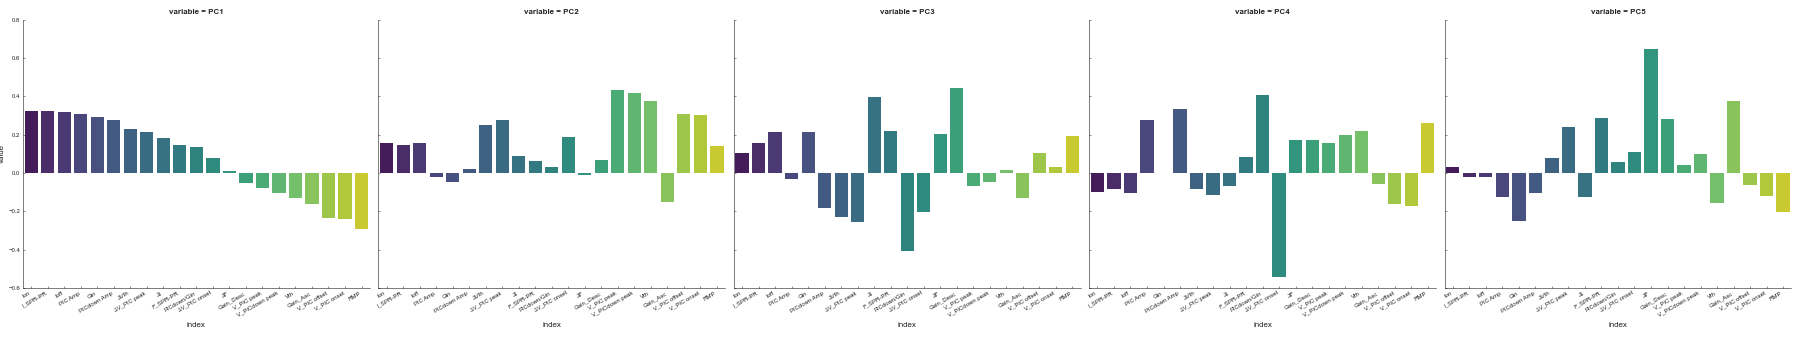

In [33]:
a = pca_factors.reset_index().melt(id_vars=['index'])
g = sns.catplot(kind='bar', data=a, x='index', y='value', col='variable', palette='viridis')
g.fig.autofmt_xdate()

In [34]:
pca_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
pca_loadings = pd.DataFrame(pca_loadings, columns=[f'PC{i+1}' for i in range(n_pca)], 
                       index=X.columns)
pca_loadings.reindex(pca_loadings.abs().sort_values(by='PC1', ascending=False).index)

,PC1,PC2,PC3,PC4,PC5
Ion,0.870007,0.331714,0.166123,-0.141852,0.036131
I_SPR-PR,0.869399,0.311352,0.245024,-0.116585,-0.026824
Ioff,0.848660,0.333299,0.340620,-0.147203,-0.024444
PIC Amp,0.825432,-0.044914,-0.052042,0.387275,-0.153776
Gin,0.786197,-0.105484,0.337933,-0.001637,-0.309039
RMP,-0.778396,0.302272,0.305142,0.365995,-0.247609
PICdown Amp,0.738743,0.041847,-0.293633,0.472009,-0.126958
V_PIC onset,-0.641633,0.646179,0.049430,-0.243504,-0.146416
V_PIC offset,-0.632927,0.657441,0.165180,-0.226680,-0.074470
∆Vth,0.609118,0.536998,-0.367031,-0.117470,0.098703


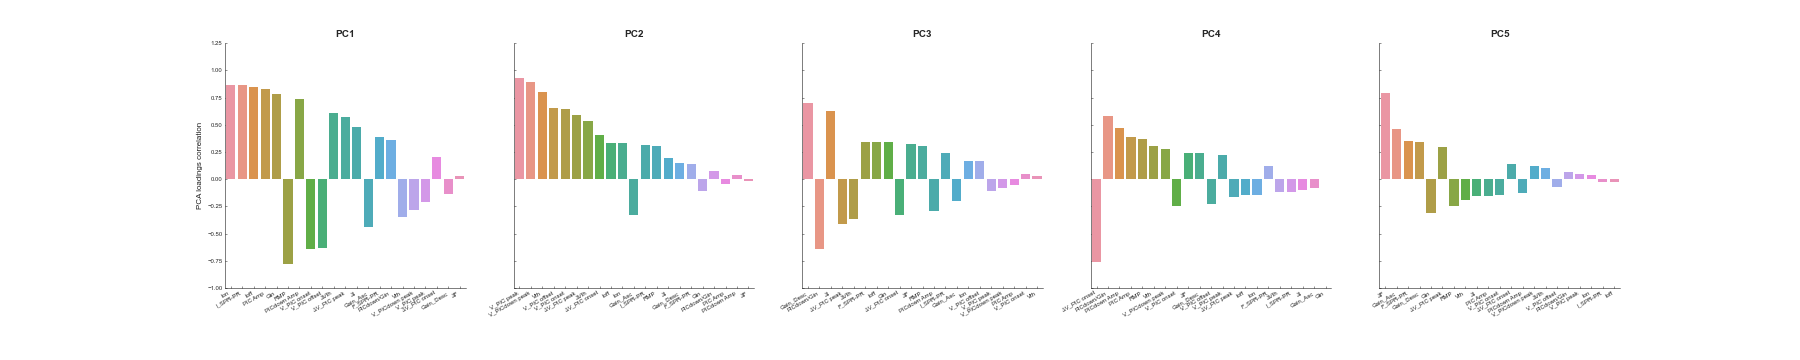

In [35]:
fig, axs = plt.subplots(1,n_pca, sharey=True, figsize=(n_pca*5,5))
for (col,g),ax in zip(pca_loadings.iteritems(), axs):
    h = g.reindex(g.abs().sort_values(ascending=False).index)
    sns.barplot(x=h.index, y=h.values, ax=ax)
    ax.set_title(col)
axs[0].set_ylabel('PCA loadings correlation')
fig.autofmt_xdate()


In [36]:
pca.explained_variance_ratio_

array([0.33783582, 0.21407811, 0.11870783, 0.09368224, 0.0702616 ])

In [37]:
np.cumsum(pca.explained_variance_ratio_)

array([0.33783582, 0.55191392, 0.67062175, 0.76430399, 0.83456559])

Scree plot

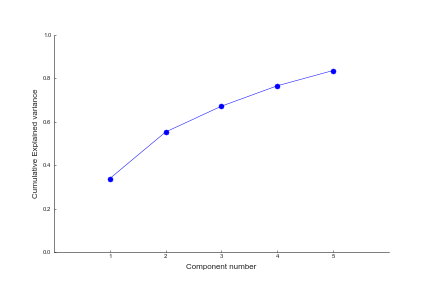

In [38]:
fig, ax = plt.subplots()
ax.plot(1+np.arange(n_pca),np.cumsum(pca.explained_variance_ratio_), 'bo-')
ax.set_ylabel('Cumulative Explained variance')
ax.set_xlabel('Component number')
ax.set_ylim(0,1)
ax.set_xticks(1+np.arange(n_pca));

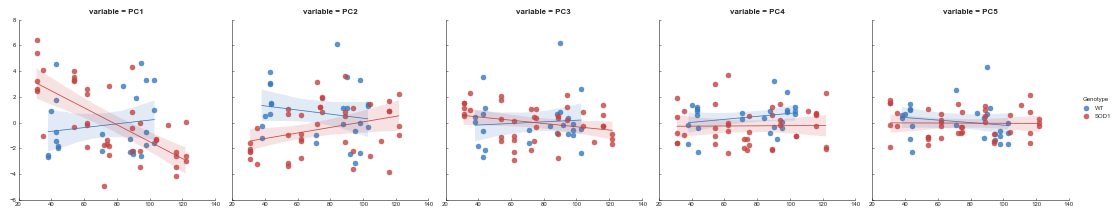

In [39]:
temp = data_pca.melt(id_vars=['MouseAge','AgeGroup','Genotype','G+A'], value_vars=[f'PC{i+1}' for i in range(n_pca)])
g = sns.FacetGrid(data=temp, col='variable', hue='Genotype', hue_order=genotypeOrder, aspect=1)
g.map_dataframe(sns.regplot, x='MouseAge', y='value')
g.add_legend()

In [40]:
est = None
for g in ['WT','SOD1']:
    display(md(f' - **{g}**'))
    for pc in [f'PC{i+1}' for i in range(n_pca)]:
        est = smf.ols(formula=f"{pc} ~ MouseAgeWks", data=data_pca.loc[data_pca['Genotype']==g]).fit()
        print(pc,':', print_slope_stats(est, 'MouseAgeWks', units='AU/week', precision='.3f'))

 - **WT**

PC1 : slope=0.102 AU/week 95%CI[−0.178–0.381], r^2=0.024 (p=0.459)
PC2 : slope=−0.112 AU/week 95%CI[−0.368–0.144], r^2=0.034 (p=0.376)
PC3 : slope=0.043 AU/week 95%CI[−0.182–0.269], r^2=0.007 (p=0.694)
PC4 : slope=0.081 AU/week 95%CI[−0.054–0.217], r^2=0.063 (p=0.227)
PC5 : slope=−0.069 AU/week 95%CI[−0.237–0.100], r^2=0.030 (p=0.408)


 - **SOD1**

PC1 : slope=−0.460 AU/week 95%CI[−0.625–−0.295], r^2=0.450 (p=0.000)
PC2 : slope=0.151 AU/week 95%CI[0.006–0.296], r^2=0.102 (p=0.042)
PC3 : slope=−0.089 AU/week 95%CI[−0.192–0.013], r^2=0.074 (p=0.086)
PC4 : slope=0.004 AU/week 95%CI[−0.111–0.120], r^2=0.000 (p=0.941)
PC5 : slope=−0.003 AU/week 95%CI[−0.087–0.080], r^2=0.000 (p=0.941)


# Ascending vs. Descending legs

In [41]:
asc_props = ['PIC Amp','V_PIC onset','V_PIC peak','Ion','Gain_Asc']
desc_props = ['PICdown Amp','V_PIC offset','V_PICdown peak','Ioff','Gain_Desc']

PIC Amp 0.7503168347376664
V_PIC onset 0.8936003592681248
V_PIC peak 0.9045867704048561
Ion 0.9034685920355642
Gain_Asc 0.0019511572908916424


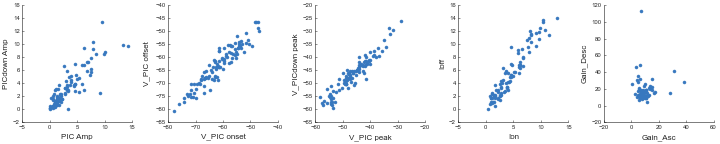

In [42]:
fig, axs = plt.subplots(1, len(asc_props), figsize=(2*len(asc_props), 2), constrained_layout=True)
for ax,asc_p,desc_p in zip(axs.flat, asc_props, desc_props):
    ax.plot(*data[[asc_p,desc_p]].values.T, 'o', ms=3)
    ax.set_xlabel(asc_p)
    ax.set_ylabel(desc_p)
    s,i,r,p,e = st.linregress(data[[asc_p,desc_p]].dropna().values)
    print(asc_p, r**2)

We're focusing on the ascending part of the ramps for the most part

## Comparisons WT vs. mSOD1

In [43]:
effects = pd.DataFrame()
mean_diffs = {}
hedges_gs = {}

for prop in prop_labels.keys():
    a = dabest.load(data=data[['G+A',prop]], idx=idx,x="G+A", y=prop)
    mean_diffs[prop] = a.mean_diff
    hedges_gs[prop] = a.hedges_g
    b = a.mean_diff.statistical_tests
    c = a.hedges_g.statistical_tests
    d = b.append(c)
    d['prop'] = prop
    d['AgeGroup'] = ['P30–60','P60–90','P90–120']*2
    effects = effects.append(d)

In [44]:
temp = effects.pivot_table(index=['prop'], columns=['AgeGroup','effect_size'], values=['difference','bca_low','bca_high'])
temp = temp.swaplevel(0,2, axis=1).sort_index(axis=1).reindex(['difference','bca_low','bca_high'], level=2, axis=1)
temp.rename(columns={'difference':'es','bca_low':'lo','bca_high':'hi'}, level=2, inplace=True)
effects = temp.sort_values(by=('Hedges\' g','P30–60','es'), ascending=False)
effects.head()

effect_size Hedges' g                                                    \
AgeGroup       P30–60                        P60–90                       
                   es        lo        hi        es        lo        hi   
prop                                                                      
Gin          1.729220  0.929597  2.395633 -0.283289 -0.957662  0.388832   
PIC Amp      1.592659  0.622757  2.475014  0.124986 -0.525093  0.668559   
PICdown Amp  0.937128  0.153642  1.704153  0.251659 -0.498272  0.819419   
I_SPR-PR     0.689803 -0.480829  1.677877 -0.287239 -1.336393  0.480836   
Ion          0.501863 -0.251791  1.260805 -0.240467 -0.938222  0.431055   

effect_size                               mean difference                      \
AgeGroup      P90–120                              P30–60                       
                   es        lo        hi              es        lo        hi   
prop                                                                            
Gin         -1.850730 -2.569251 -1.167043        0.303439  0.192912  0.416632   
PIC Amp     -0.735718 -1.265832  0.000411        4.426667  2.560351  6.291228   
PICdown Amp -0.807794 -1.494275 -0.026261        2.899930  0.859123  4.890421   
I_SPR-PR    -1.230853 -2.072639 -0.346974        2.075952 -0.946032  4.077778   
Ion         -1.263780 -1.955491 -0.523516        1.488554 -0.650000  3.217918   

effect_size                                                              
AgeGroup       P60–90                       P90–120                      
                   es        lo        hi        es        lo        hi  
prop                                                                     
Gin         -0.043750 -0.139167  0.053542 -0.268857 -0.371190 -0.174952  
PIC Amp      0.273750 -0.931250  1.533333 -2.220000 -4.630000 -0.414762  
PICdown Amp  0.577083 -1.026667  1.762917 -2.178524 -3.987714 -0.340524  
I_SPR-PR    -1.043582 -4.721250  1.385336 -3.195692 -5.235154 -1.275615  
Ion         -0.757032 -2.565187  1.274563 -3.236103 -4.977692 -1.629897

## Effect size vs time

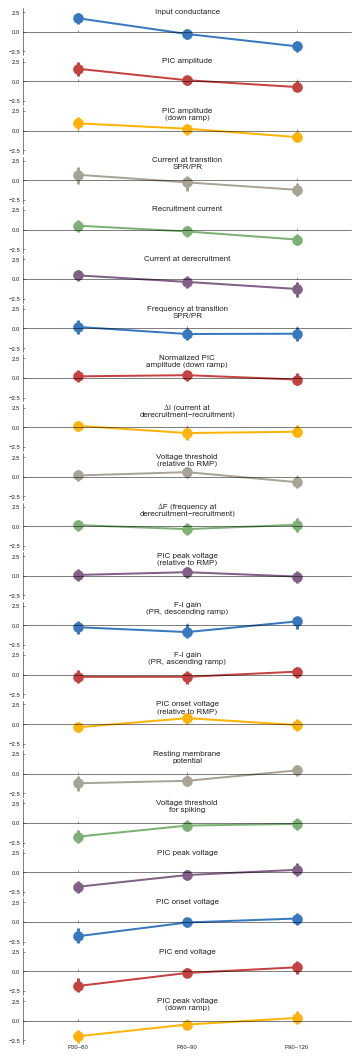

In [45]:
idx = pd.IndexSlice
w = 5
h = 0.7

cycler = itertools.cycle(plt.rcParams['axes.prop_cycle']) # color iterator
    
fig, axs = plt.subplots(effects.index.size,1, 
                        figsize=(w,h*effects.index.size), 
                        sharex=True, sharey=True)

for (prop,row),ax in zip(effects.loc[:,idx['Hedges\' g',:,:]].iterrows(), axs):
    sns.despine(ax=ax)
    c = next(cycler)['color']
    es = row[idx[:,:,'es']].values
    err = np.abs(np.vstack([row[:,:,'lo'].values,row[:,:,'hi'].values])-es)
    ax.errorbar(x=range(len(es)), y=es, yerr=err, fmt='o-', ms=10, lw=2, c=c, elinewidth=3, capsize=0, label=prop_labels[prop])
    ax.spines['bottom'].set_position('zero')
    ax.annotate(prop_labels[prop], xy=(0.5,1), xycoords='axes fraction', va='top', ha='center')
    
axs[-1].set_xlim(-0.5,2.5)
axs[-1].set_ylim(-3,3)
axs[-1].set_xticks(range(len(ageOrder)))
axs[-1].set_xticklabels([])
for i,age in enumerate(ageOrder):
    axs[-1].annotate(age, xy=(i,0), xycoords=('data','axes fraction'), va='top', ha='center', fontsize=plt.rcParams['xtick.labelsize'])
    

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

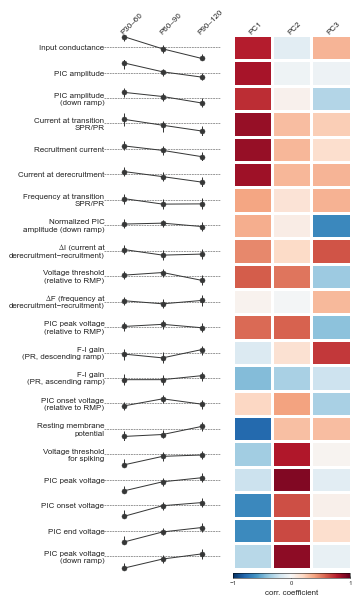

In [46]:
idx = pd.IndexSlice
w = 5
h = 0.4

fig = plt.figure(figsize=(w, h*effects.index.size))
gs0 = gridspec.GridSpec(effects.index.size+2, 2, figure=fig, height_ratios=[1]*effects.index.size+[0.1]+[0.2])
axs = np.empty(effects.index.size, dtype=object)
for i in range(effects.index.size):
    axs[i] = fig.add_subplot(gs0[i,0], sharex=axs[0], sharey=axs[0])
    axs[i].axis('off')
    axs[i].axhline(0, ls='--', color='xkcd:dark grey')

for (prop,row),ax in zip(effects.loc[:,idx['Hedges\' g',:,:]].iterrows(), axs):
    es = row[idx[:,:,'es']].values
    err = np.abs(np.vstack([row[:,:,'lo'].values,row[:,:,'hi'].values])-es)
    ax.errorbar(x=range(len(es)), y=es, yerr=err, fmt='o-', ms=5, lw=1, 
                c='xkcd:dark grey', elinewidth=1, capsize=0, label=prop_labels[prop],
                clip_on=False)
    ax.annotate(prop_labels[prop], xy=(0,0.5), xycoords='axes fraction', va='center', ha='right')
    
axs[-1].set_xlim(-0.5,2.5)
axs[-1].set_ylim(-2,2)
for i,age in enumerate(ageOrder):
    axs[0].annotate(age, xy=(i,1), xycoords=('data','axes fraction'), 
                    va='bottom', ha='left', fontsize=plt.rcParams['axes.labelsize'],
                   rotation=45, rotation_mode='anchor')
    
corr_data = pca_loadings.reindex(effects.index).iloc[:,:3]
from matplotlib.colors import TwoSlopeNorm
cmap = 'RdBu_r'
norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
ax = fig.add_subplot(gs0[:-2,1])
cax = fig.add_subplot(gs0[-1,1])
im = ax.imshow(corr_data, aspect='auto', cmap=cmap, norm=norm)
fig.colorbar(im, orientation='horizontal', cax=cax, label='corr. coefficient', ticks=[-1,0,1])
for i,l in enumerate(corr_data.columns):
    ax.annotate(l, xy=(i,1), xycoords=('data','axes fraction'), 
                    va='bottom', ha='left', fontsize=plt.rcParams['axes.labelsize'],
                   rotation=45, rotation_mode='anchor')

#ax.axis('off')
for s in ax.spines:
    ax.spines[s].set_visible(False)
ax.set_xticks(np.arange(corr_data.columns.size)-0.5)
ax.set_xticklabels([])
ax.set_yticks(np.arange(corr_data.index.size)-0.5)
ax.set_yticklabels([])
plt.setp(ax.yaxis.get_ticklines(), visible=False)
plt.setp(ax.xaxis.get_ticklines(), visible=False)
ax.grid(True, color='white', linestyle='-', linewidth=3)


fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

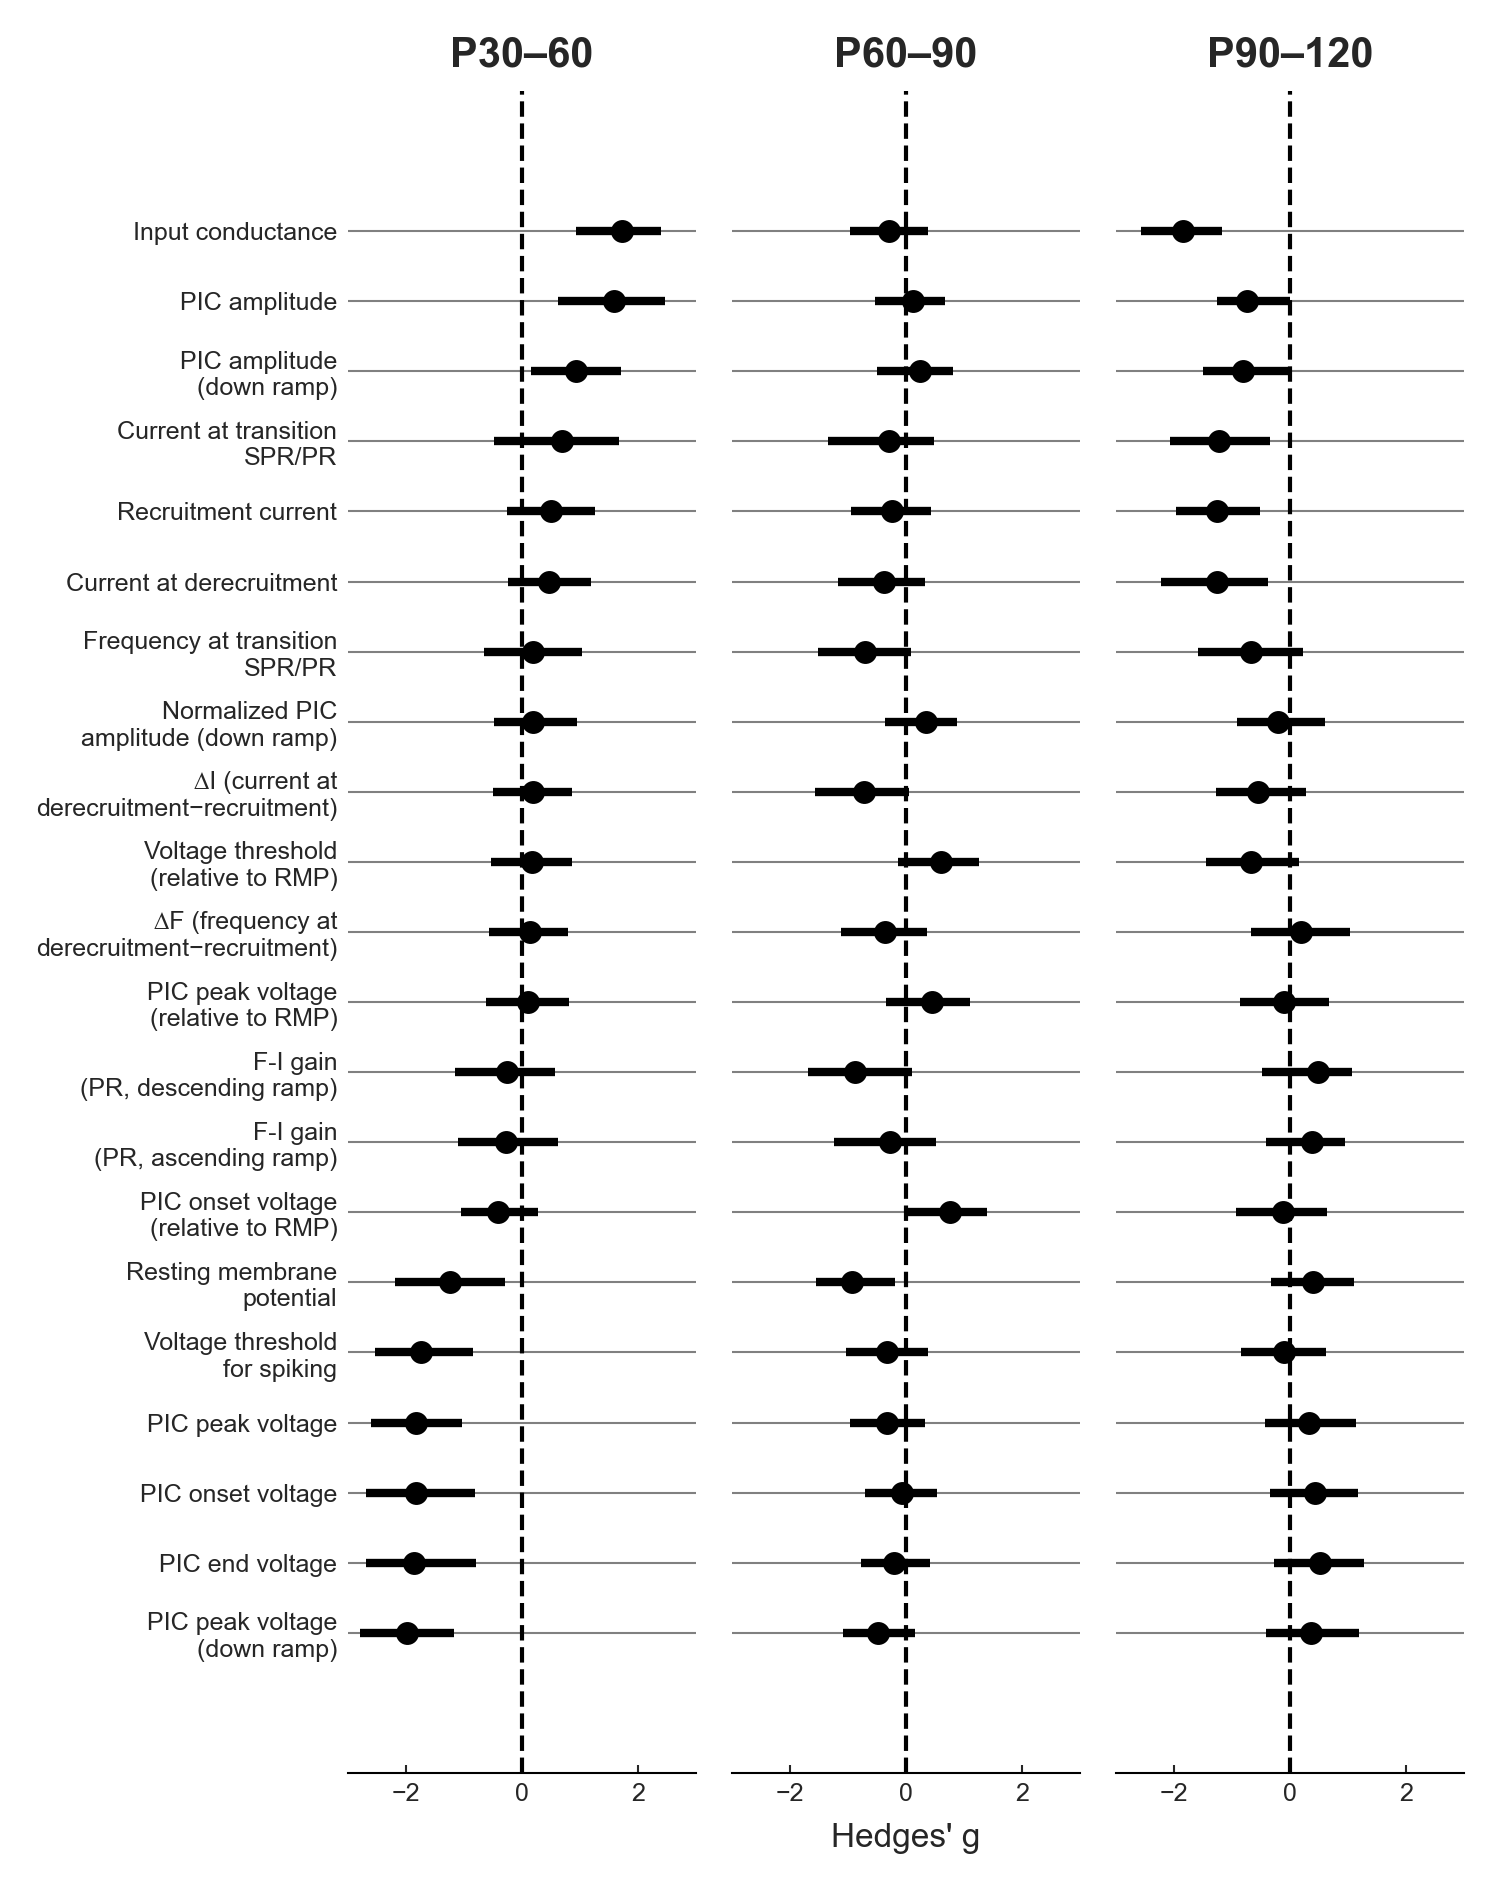

In [47]:
Nprops = effects.index.size
w = 5
h = 0.3
fig, axs = plt.subplots(1,3, sharey=True, figsize=(w,h*Nprops), dpi=300)
for age,ax in zip(ageOrder, axs):
    ax.set_xlim(-3,3)
    x = effects[('Hedges\' g',age,'es')].values
    y = effects[('Hedges\' g',age,'es')].index.map(prop_labels)
    x_low = effects[('Hedges\' g',age,'lo')].values
    x_high = effects[('Hedges\' g',age,'hi')].values
    ax.plot(x,y, 'ko')
    ax.hlines(y, x_low, x_high, lw=2, color='k')
    ax.hlines(y,*ax.get_xlim(), lw=0.5, color='grey', zorder=-1)
    ax.set_title(age)
    ax.axvline(0,ls='--',c='k', lw=1)
    sns.despine(left=True, right=True, top=True, bottom=False)
    for tick in ax.get_yticklines():
        tick.set_visible(False)

ymin,ymax = ax.get_ylim()
ax.set_ylim(ymin-1, ymax+1)
ax.invert_yaxis()

axs[1].set_xlabel('Hedges\' g')
fig.tight_layout()

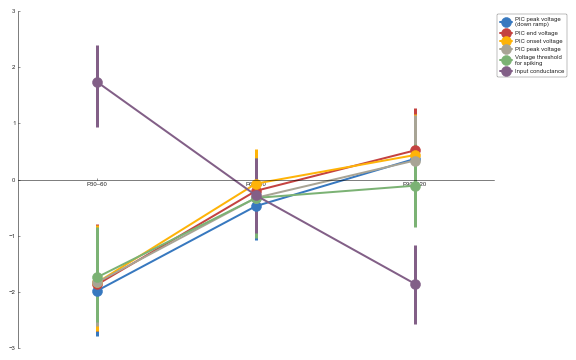

In [48]:
N=6

top = effects['Hedges\' g','P30–60','es'].abs().sort_values(ascending=False).head(N).index

idx = pd.IndexSlice
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylim(-3,3)
ax.set_xlim(-0.5,2.5)
ax.spines['bottom'].set_position('zero')
sns.despine(ax=ax)
for prop,row in effects.loc[top,idx['Hedges\' g',:,:]].iterrows():
    es = row[idx[:,:,'es']].values
    err = np.abs(np.vstack([row[:,:,'lo'].values,row[:,:,'hi'].values])-es)
    ax.errorbar(x=range(len(es)), y=es, yerr=err, fmt='o-', ms=10, lw=2, elinewidth=3, capsize=0, label=prop_labels[prop])
ax.legend(loc=2, bbox_to_anchor=(1,1))
ax.set_xticks(range(len(ageOrder)))
ax.set_xticklabels(ageOrder)
fig.tight_layout()

### PIC Amp

In [49]:
prop = 'PIC Amp'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 2.30±2.17nA, N=19 vs. SOD1: 6.73±3.28nA, N=15; *g*=1.59 95%CI[0.63–2.45]; *t*(32)=−4.50, *p*=0.00016

 - P60–90

WT: 2.47±1.69nA, N=16 vs. SOD1: 2.75±2.40nA, N=24; *g*=0.12 95%CI[−0.53–0.65]; *t*(38)=−0.42, *p*=0.67

 - P90–120

WT: 4.12±3.69nA, N=15 vs. SOD1: 1.90±1.78nA, N=14; *g*=−0.74 95%CI[−1.26–0.01]; *t*(27)=2.08, *p*=0.05

complete output:


P30–60 WT: 2.30±2.17nA, N=19 vs. SOD1: 6.73±3.28nA, N=15; *g*=1.59 95%CI[0.63–2.45]; *t*(32)=−4.50, *p*=0.00016. P60–90 WT: 2.47±1.69nA, N=16 vs. SOD1: 2.75±2.40nA, N=24; *g*=0.12 95%CI[−0.53–0.65]; *t*(38)=−0.42, *p*=0.67. P90–120 WT: 4.12±3.69nA, N=15 vs. SOD1: 1.90±1.78nA, N=14; *g*=−0.74 95%CI[−1.26–0.01]; *t*(27)=2.08, *p*=0.05. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


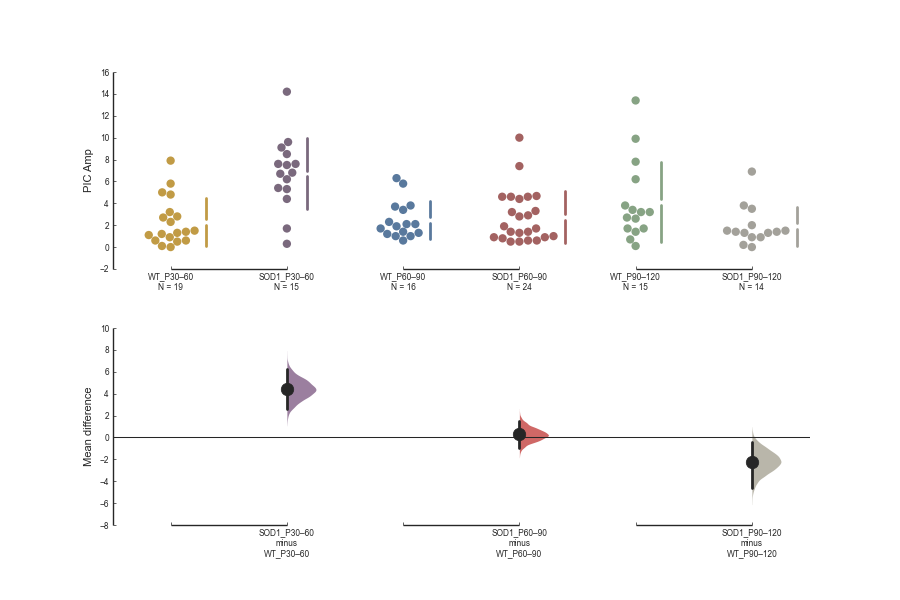

In [50]:
mean_diffs[prop].plot();

#### Regression PIC Amp vs. Age

<AxesSubplot:xlabel='MouseAge', ylabel='PIC Amp'>

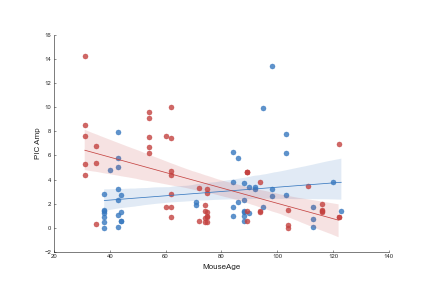

In [51]:
fig, ax = plt.subplots()
sns.regplot(data=data.loc[data['Genotype']=='WT'], x='MouseAge',y='PIC Amp', label='WT')
sns.regplot(data=data.loc[data['Genotype']=='SOD1'], x='MouseAge',y='PIC Amp', label='SOD1')

In [52]:
param = 'PIC Amp'
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=0.12 nA/week 95%CI[−0.068–0.32], r^2=0.034 (p=0.2)


 - **SOD1**

slope=−0.45 nA/week 95%CI[−0.64–−0.25], r^2=0.29 (p=3.4e−05)


### PIC onset voltage

In [53]:
prop = 'V_PIC onset'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −58.03±6.35mV, N=19 vs. SOD1: −69.41±5.71mV, N=15; *g*=−1.83 95%CI[−2.64–−0.78]; *t*(32)=5.49, *p*=5.1e−06

 - P60–90

WT: −59.23±4.88mV, N=16 vs. SOD1: −59.66±6.39mV, N=24; *g*=−0.07 95%CI[−0.70–0.52]; *t*(38)=0.24, *p*=0.81

 - P90–120

WT: −63.15±6.31mV, N=15 vs. SOD1: −60.12±7.25mV, N=14; *g*=0.43 95%CI[−0.33–1.21]; *t*(27)=−1.20, *p*=0.24

complete output:


P30–60 WT: −58.03±6.35mV, N=19 vs. SOD1: −69.41±5.71mV, N=15; *g*=−1.83 95%CI[−2.64–−0.78]; *t*(32)=5.49, *p*=5.1e−06. P60–90 WT: −59.23±4.88mV, N=16 vs. SOD1: −59.66±6.39mV, N=24; *g*=−0.07 95%CI[−0.70–0.52]; *t*(38)=0.24, *p*=0.81. P90–120 WT: −63.15±6.31mV, N=15 vs. SOD1: −60.12±7.25mV, N=14; *g*=0.43 95%CI[−0.33–1.21]; *t*(27)=−1.20, *p*=0.24. 

In [54]:
param = 'V_PIC onset'
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=−0.33 mV/week 95%CI[−0.77–0.11], r^2=0.045 (p=0.14)


 - **SOD1**

slope=0.91 mV/week 95%CI[0.41–1.4], r^2=0.21 (p=0.00063)


### PIC peak voltage

In [55]:
prop = 'V_PIC peak'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −43.83±4.79mV, N=19 vs. SOD1: −52.32±4.20mV, N=15; *g*=−1.83 95%CI[−2.63–−1.04]; *t*(32)=5.50, *p*=4.8e−06

 - P60–90

WT: −42.89±6.94mV, N=16 vs. SOD1: −44.88±5.24mV, N=24; *g*=−0.33 95%CI[−0.99–0.33]; *t*(38)=0.97, *p*=0.34

 - P90–120

WT: −48.34±5.89mV, N=15 vs. SOD1: −46.24±6.27mV, N=14; *g*=0.34 95%CI[−0.42–1.14]; *t*(27)=−0.93, *p*=0.36

complete output:


P30–60 WT: −43.83±4.79mV, N=19 vs. SOD1: −52.32±4.20mV, N=15; *g*=−1.83 95%CI[−2.63–−1.04]; *t*(32)=5.50, *p*=4.8e−06. P60–90 WT: −42.89±6.94mV, N=16 vs. SOD1: −44.88±5.24mV, N=24; *g*=−0.33 95%CI[−0.99–0.33]; *t*(38)=0.97, *p*=0.34. P90–120 WT: −48.34±5.89mV, N=15 vs. SOD1: −46.24±6.27mV, N=14; *g*=0.34 95%CI[−0.42–1.14]; *t*(27)=−0.93, *p*=0.36. 

In [56]:
param = 'V_PIC peak'
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=−0.29 mV/week 95%CI[−0.73–0.16], r^2=0.034 (p=0.2)


 - **SOD1**

slope=0.68 mV/week 95%CI[0.28–1.1], r^2=0.18 (p=0.0014)


### Vth

In [57]:
prop = 'Vth'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −45.35±5.48mV, N=19 vs. SOD1: −54.86±5.15mV, N=14; *g*=−1.74 95%CI[−2.53–−0.81]; *t*(31)=5.10, *p*=1.9e−05

 - P60–90

WT: −45.39±7.04mV, N=16 vs. SOD1: −47.53±5.85mV, N=20; *g*=−0.33 95%CI[−1.01–0.41]; *t*(34)=0.98, *p*=0.34

 - P90–120

WT: −47.61±5.00mV, N=15 vs. SOD1: −48.20±5.41mV, N=13; *g*=−0.11 95%CI[−0.89–0.66]; *t*(26)=0.30, *p*=0.77

complete output:


P30–60 WT: −45.35±5.48mV, N=19 vs. SOD1: −54.86±5.15mV, N=14; *g*=−1.74 95%CI[−2.53–−0.81]; *t*(31)=5.10, *p*=1.9e−05. P60–90 WT: −45.39±7.04mV, N=16 vs. SOD1: −47.53±5.85mV, N=20; *g*=−0.33 95%CI[−1.01–0.41]; *t*(34)=0.98, *p*=0.34. P90–120 WT: −47.61±5.00mV, N=15 vs. SOD1: −48.20±5.41mV, N=13; *g*=−0.11 95%CI[−0.89–0.66]; *t*(26)=0.30, *p*=0.77. 

In [58]:
param = 'Vth'
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=−0.14 mV/week 95%CI[−0.57–0.28], r^2=0.0096 (p=0.5)


 - **SOD1**

slope=0.77 mV/week 95%CI[0.34–1.2], r^2=0.23 (p=0.0007)


### Recruitment current

In [59]:
prop = 'Ion'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 4.73±3.14nA, N=19 vs. SOD1: 6.21±2.51nA, N=14; *g*=0.50 95%CI[−0.24–1.24]; *t*(31)=−1.51, *p*=0.14

 - P60–90

WT: 5.28±2.64nA, N=16 vs. SOD1: 4.53±3.38nA, N=20; *g*=−0.24 95%CI[−0.93–0.41]; *t*(34)=0.75, *p*=0.46

 - P90–120

WT: 5.43±3.07nA, N=15 vs. SOD1: 2.19±1.56nA, N=13; *g*=−1.26 95%CI[−1.95–−0.47]; *t*(26)=3.59, *p*=0.0017

complete output:


P30–60 WT: 4.73±3.14nA, N=19 vs. SOD1: 6.21±2.51nA, N=14; *g*=0.50 95%CI[−0.24–1.24]; *t*(31)=−1.51, *p*=0.14. P60–90 WT: 5.28±2.64nA, N=16 vs. SOD1: 4.53±3.38nA, N=20; *g*=−0.24 95%CI[−0.93–0.41]; *t*(34)=0.75, *p*=0.46. P90–120 WT: 5.43±3.07nA, N=15 vs. SOD1: 2.19±1.56nA, N=13; *g*=−1.26 95%CI[−1.95–−0.47]; *t*(26)=3.59, *p*=0.0017. 

In [60]:
param = prop
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=0.1 nA/week 95%CI[−0.11–0.31], r^2=0.019 (p=0.34)


 - **SOD1**

slope=−0.35 nA/week 95%CI[−0.56–−0.14], r^2=0.2 (p=0.0019)


/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


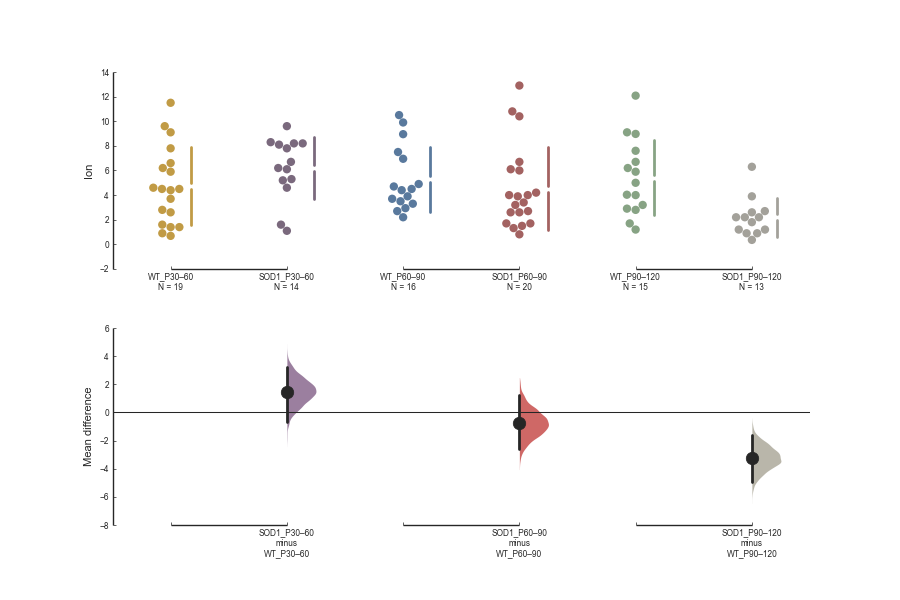

In [61]:
mean_diffs[prop].plot();

### F-I gain

In [62]:
prop = 'Gain_Asc'
units = prop_units[prop]
precision = '.1f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 9.3±3.6Hz/nA, N=10 vs. SOD1: 8.3±3.4Hz/nA, N=14; *g*=−0.28 95%CI[−1.10–0.64]; *t*(22)=0.69, *p*=0.5

 - P60–90

WT: 12.2±7.3Hz/nA, N=8 vs. SOD1: 10.3±6.4Hz/nA, N=16; *g*=−0.27 95%CI[−1.22–0.54]; *t*(22)=0.62, *p*=0.54

 - P90–120

WT: 8.0±3.2Hz/nA, N=10 vs. SOD1: 10.8±9.1Hz/nA, N=13; *g*=0.38 95%CI[−0.43–0.93]; *t*(21)=−1.04, *p*=0.31

complete output:


P30–60 WT: 9.3±3.6Hz/nA, N=10 vs. SOD1: 8.3±3.4Hz/nA, N=14; *g*=−0.28 95%CI[−1.10–0.64]; *t*(22)=0.69, *p*=0.5. P60–90 WT: 12.2±7.3Hz/nA, N=8 vs. SOD1: 10.3±6.4Hz/nA, N=16; *g*=−0.27 95%CI[−1.22–0.54]; *t*(22)=0.62, *p*=0.54. P90–120 WT: 8.0±3.2Hz/nA, N=10 vs. SOD1: 10.8±9.1Hz/nA, N=13; *g*=0.38 95%CI[−0.43–0.93]; *t*(21)=−1.04, *p*=0.31. 

In [63]:
param = prop
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=−0.13 Hz/nA/week 95%CI[−0.65–0.38], r^2=0.011 (p=0.6)


 - **SOD1**

slope=0.27 Hz/nA/week 95%CI[−0.23–0.77], r^2=0.028 (p=0.28)


### Input conductance

In [64]:
prop = 'Gin'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 0.42±0.16μS, N=19 vs. SOD1: 0.72±0.18μS, N=15; *g*=1.73 95%CI[0.92–2.41]; *t*(32)=−5.06, *p*=2.2e−05

 - P60–90

WT: 0.46±0.16μS, N=16 vs. SOD1: 0.42±0.15μS, N=24; *g*=−0.28 95%CI[−0.96–0.37]; *t*(38)=0.88, *p*=0.39

 - P90–120

WT: 0.60±0.15μS, N=15 vs. SOD1: 0.33±0.13μS, N=14; *g*=−1.85 95%CI[−2.57–−1.16]; *t*(27)=5.16, *p*=2.1e−05

complete output:


P30–60 WT: 0.42±0.16μS, N=19 vs. SOD1: 0.72±0.18μS, N=15; *g*=1.73 95%CI[0.92–2.41]; *t*(32)=−5.06, *p*=2.2e−05. P60–90 WT: 0.46±0.16μS, N=16 vs. SOD1: 0.42±0.15μS, N=24; *g*=−0.28 95%CI[−0.96–0.37]; *t*(38)=0.88, *p*=0.39. P90–120 WT: 0.60±0.15μS, N=15 vs. SOD1: 0.33±0.13μS, N=14; *g*=−1.85 95%CI[−2.57–−1.16]; *t*(27)=5.16, *p*=2.1e−05. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


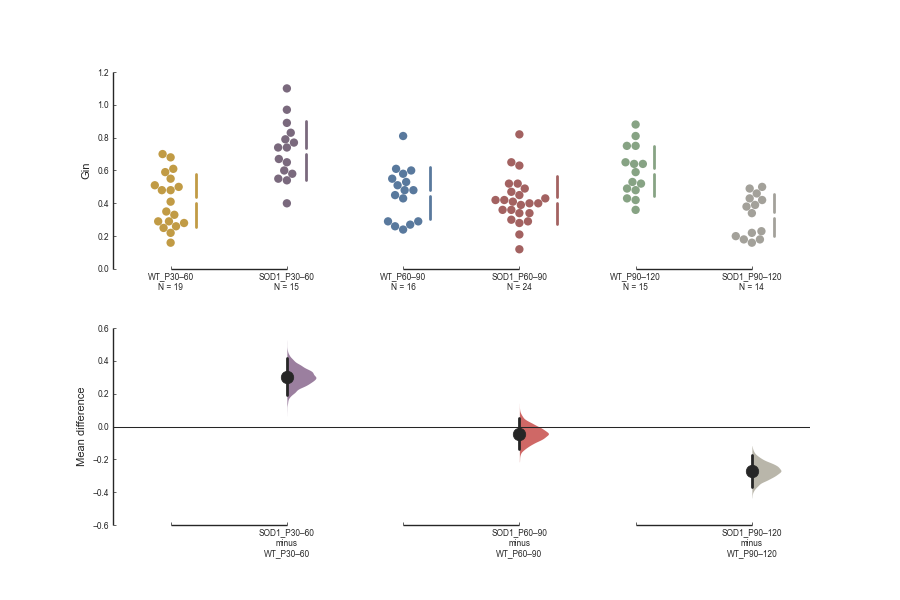

In [65]:
mean_diffs[prop].plot();

#### Regression Gin vs. Age

<AxesSubplot:xlabel='MouseAge', ylabel='Gin'>

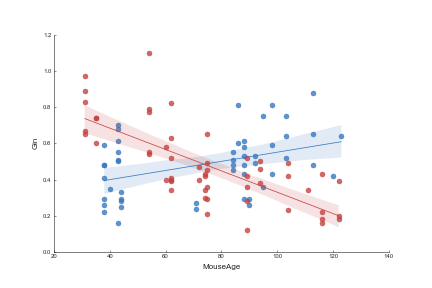

In [66]:
fig, ax = plt.subplots()
sns.regplot(data=data.loc[data['Genotype']=='WT'], x='MouseAge',y='Gin', label='WT')
sns.regplot(data=data.loc[data['Genotype']=='SOD1'], x='MouseAge',y='Gin', label='SOD1')

In [67]:
param = prop
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=0.018 μS/week 95%CI[0.0061–0.029], r^2=0.16 (p=0.0035)


 - **SOD1**

slope=−0.041 μS/week 95%CI[−0.052–−0.03], r^2=0.53 (p=6.1e−10)


### RMP

In [68]:
prop = 'RMP'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: −62.38±5.52mV, N=19 vs. SOD1: −71.45±8.78mV, N=15; *g*=−1.24 95%CI[−2.13–−0.23]; *t*(32)=3.49, *p*=0.002

 - P60–90

WT: −60.98±5.35mV, N=16 vs. SOD1: −66.18±5.63mV, N=22; *g*=−0.92 95%CI[−1.54–−0.18]; *t*(36)=2.89, *p*=0.0067

 - P90–120

WT: −64.71±7.42mV, N=15 vs. SOD1: −61.99±5.43mV, N=13; *g*=0.40 95%CI[−0.35–1.10]; *t*(26)=−1.12, *p*=0.27

complete output:


P30–60 WT: −62.38±5.52mV, N=19 vs. SOD1: −71.45±8.78mV, N=15; *g*=−1.24 95%CI[−2.13–−0.23]; *t*(32)=3.49, *p*=0.002. P60–90 WT: −60.98±5.35mV, N=16 vs. SOD1: −66.18±5.63mV, N=22; *g*=−0.92 95%CI[−1.54–−0.18]; *t*(36)=2.89, *p*=0.0067. P90–120 WT: −64.71±7.42mV, N=15 vs. SOD1: −61.99±5.43mV, N=13; *g*=0.40 95%CI[−0.35–1.10]; *t*(26)=−1.12, *p*=0.27. 

/Users/manuel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


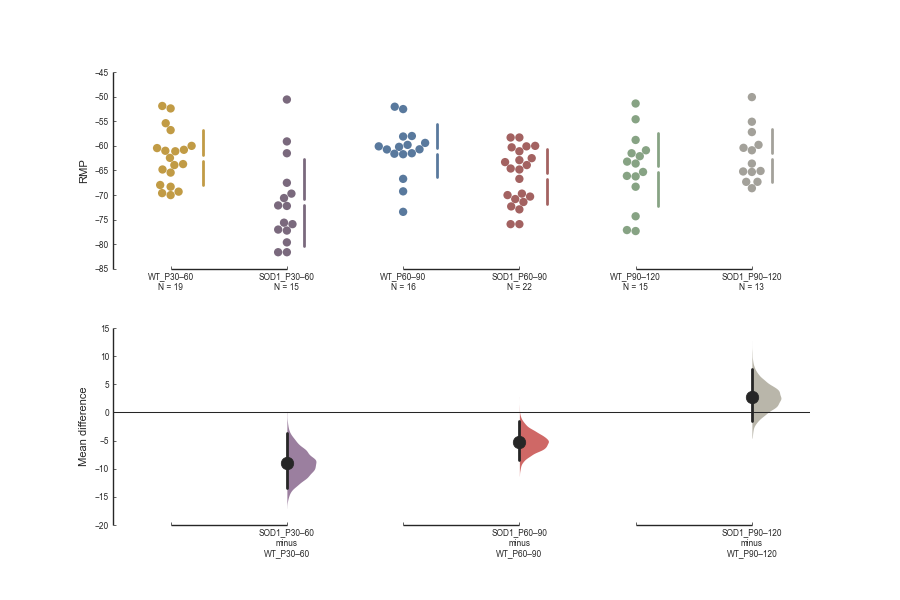

In [69]:
mean_diffs[prop].plot();

In [70]:
param = prop
for gen in genotypeOrder:
    display(md(f" - **{gen}**"))
    res = smf.ols(f'Q("{param}") ~ MouseAgeWks', data=data.loc[data['Genotype']==gen,['MouseAgeWks',param]].dropna()).fit()
    print(print_slope_stats(res, 'MouseAgeWks', prop_units[param]+'/week'))

 - **WT**

slope=−0.068 mV/week 95%CI[−0.52–0.38], r^2=0.0019 (p=0.76)


 - **SOD1**

slope=0.81 mV/week 95%CI[0.31–1.3], r^2=0.18 (p=0.0022)


### Normalized PIC Amp

In [71]:
prop = 'PIC/Gin'
units = prop_units[prop]
precision = '.2f'
full = ''
for age in ageOrder:
    out = compare_WT_SOD(data.loc[data['AgeGroup']==age].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 
    display(md(f' - {age}'))
    display(md(out))
    full += age+' '
    full += out
    full += '. '
print('complete output:')
display(md(full))

 - P30–60

WT: 5.35±4.11nA/μS, N=19 vs. SOD1: 9.32±3.94nA/μS, N=15; *g*=0.96 95%CI[0.16–1.76]; *t*(32)=−2.86, *p*=0.0075

 - P60–90

WT: 5.65±3.35nA/μS, N=16 vs. SOD1: 6.46±5.39nA/μS, N=24; *g*=0.17 95%CI[−0.50–0.66]; *t*(38)=−0.59, *p*=0.56

 - P90–120

WT: 6.80±5.01nA/μS, N=15 vs. SOD1: 5.93±4.53nA/μS, N=14; *g*=−0.18 95%CI[−0.88–0.63]; *t*(27)=0.49, *p*=0.63

complete output:


P30–60 WT: 5.35±4.11nA/μS, N=19 vs. SOD1: 9.32±3.94nA/μS, N=15; *g*=0.96 95%CI[0.16–1.76]; *t*(32)=−2.86, *p*=0.0075. P60–90 WT: 5.65±3.35nA/μS, N=16 vs. SOD1: 6.46±5.39nA/μS, N=24; *g*=0.17 95%CI[−0.50–0.66]; *t*(38)=−0.59, *p*=0.56. P90–120 WT: 6.80±5.01nA/μS, N=15 vs. SOD1: 5.93±4.53nA/μS, N=14; *g*=−0.18 95%CI[−0.88–0.63]; *t*(27)=0.49, *p*=0.63. 

### PIC Amp vs. Gin

In [72]:
import statsmodels.formula.api as smf

 - **P30–60**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q("PIC Amp")   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     12.42
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           1.88e-05
Time:                        14:22:13   Log-Likelihood:                -76.421
No. Observations:                  34   AIC:                             160.8
Df Residuals:                      30   BIC:                             166.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1066      2.665      0.040      0.968      -5.337       5.550
C(Genotype)[T.WT]        -0.4016      3.097     -0.130      0.898      -6.726       5.923
Gin                       9.1776      3.591      2.556      0.016       1.845      16.511
Gin:C(Genotype)[T.WT]    -2.9678      5.033     -0.590      0.560     -13.246       7.310
==============================================================================
Omnibus:                        2.375   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.231
Skew:                          -0.233   Prob(JB):                        0.540
Kurtosis:                       3.807   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 - **P60–90**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q("PIC Amp")   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.185
Date:                Sat, 02 Jan 2021   Prob (F-statistic):              0.107
Time:                        14:22:13   Log-Likelihood:                -83.024
No. Observations:                  40   AIC:                             174.0
Df Residuals:                      36   BIC:                             180.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1343      1.279      0.105      0.917      -2.460       2.728
C(Genotype)[T.WT]         0.3468      2.053      0.169      0.867      -3.817       4.511
Gin                       6.2622      2.898      2.161      0.037       0.385      12.139
Gin:C(Genotype)[T.WT]    -1.9394      4.394     -0.441      0.662     -10.852       6.973
==============================================================================
Omnibus:                       22.724   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.342
Skew:                           1.638   Prob(JB):                     2.12e-08
Kurtosis:                       6.237   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 - **P90–120**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q("PIC Amp")   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     2.656
Date:                Sat, 02 Jan 2021   Prob (F-statistic):             0.0704
Time:                        14:22:14   Log-Likelihood:                -69.377
No. Observations:                  29   AIC:                             146.8
Df Residuals:                      25   BIC:                             152.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4595      2.180      0.211      0.835      -4.030       4.949
C(Genotype)[T.WT]        -1.5307      3.748     -0.408      0.686      -9.250       6.189
Gin                       4.4032      6.243      0.705      0.487      -8.455      17.262
Gin:C(Genotype)[T.WT]     4.3068      7.976      0.540      0.594     -12.121      20.735
==============================================================================
Omnibus:                        5.371   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                3.612
Skew:                           0.753   Prob(JB):                        0.164
Kurtosis:                       3.850   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

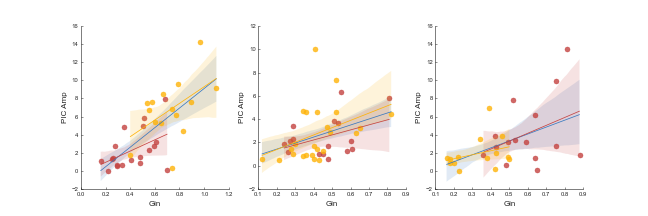

In [73]:
fig, axs = plt.subplots(1,3, figsize=(9,3))
for ax,age in zip(axs,ageOrder):
    h = data.loc[(data['AgeGroup']==age)]
    sns.regplot(data=h, x="Gin", y='PIC Amp', scatter=False, ax=ax)
    for g in genotypeOrder:
        hh = data.loc[(data['AgeGroup']==age)&(data['Genotype']==g)]
        sns.regplot(data=hh, x="Gin", y='PIC Amp', scatter=True, ax=ax)
    formula = 'Q("PIC Amp") ~ Gin * C(Genotype)'  # ANCOVA formula
    lm = smf.ols(formula, h)
    fit = lm.fit()
    display(md(f" - **{age}**"))
    display(fit.summary())

Hypothesis

In [74]:
hypotheses = 'C(Genotype)[T.WT] = 0, Gin:C(Genotype)[T.WT] = 0'
>>> t_test = fit.t_test(hypotheses)
>>> print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -1.5307      3.748     -0.408      0.686      -9.250       6.189
c1             4.3068      7.976      0.540      0.594     -12.121      20.735


In [75]:
fit.wald_test(hypotheses)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.16988681]]), p=0.8447262210520519, df_denom=25, df_num=2>

No interaction, running regression without Genotype effect

In [76]:
for ax,age in zip(axs,ageOrder):
    h = data.loc[(data['AgeGroup']==age)]
    formula = 'Q("PIC Amp") ~ Gin + C(Genotype)'  # ANCOVA formula
    lm = smf.ols(formula, h)
    fit = lm.fit()
    display(md(f" - **{age}**"))
    display(fit.summary())
    display(print_slope_stats(fit, param='Gin', units='mV', precision='.3f'))

 - **P30–60**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q("PIC Amp")   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     18.85
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           4.39e-06
Time:                        14:22:14   Log-Likelihood:                -76.617
No. Observations:                  34   AIC:                             159.2
Df Residuals:                      31   BIC:                             163.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.1963      1.901      0.629      0.534      -2.680       5.073
C(Genotype)[T.WT]    -2.1002      1.125     -1.867      0.071      -4.394       0.194
Gin                   7.6669      2.489      3.080      0.004       2.590      12.744
==============================================================================
Omnibus:                        2.813   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                1.636
Skew:                          -0.258   Prob(JB):                        0.441
Kurtosis:                       3.943   Cond. No.                         9.95
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'slope=7.667 mV 95%CI[2.590–12.744], r^2=0.549 (p=0.004)'

 - **P60–90**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q("PIC Amp")   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     3.252
Date:                Sat, 02 Jan 2021   Prob (F-statistic):             0.0500
Time:                        14:22:14   Log-Likelihood:                -83.132
No. Observations:                  40   AIC:                             172.3
Df Residuals:                      37   BIC:                             177.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.4864      0.989      0.492      0.626      -1.517       2.490
C(Genotype)[T.WT]    -0.5108      0.656     -0.779      0.441      -1.839       0.818
Gin                   5.4189      2.155      2.515      0.016       1.053       9.785
==============================================================================
Omnibus:                       22.158   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.875
Skew:                           1.604   Prob(JB):                     4.41e-08
Kurtosis:                       6.168   Cond. No.                         8.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'slope=5.419 mV 95%CI[1.053–9.785], r^2=0.149 (p=0.016)'

 - **P90–120**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Q("PIC Amp")   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     3.945
Date:                Sat, 02 Jan 2021   Prob (F-statistic):             0.0319
Time:                        14:22:14   Log-Likelihood:                -69.545
No. Observations:                  29   AIC:                             145.1
Df Residuals:                      26   BIC:                             149.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4037      1.462     -0.276      0.785      -3.408       2.601
C(Genotype)[T.WT]     0.3268      1.467      0.223      0.826      -2.690       3.343
Gin                   7.0418      3.832      1.837      0.078      -0.836      14.919
==============================================================================
Omnibus:                        7.076   Durbin-Watson:                   1.476
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                5.242
Skew:                           0.904   Prob(JB):                       0.0727
Kurtosis:                       4.035   Cond. No.                         9.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'slope=7.042 mV 95%CI[−0.836–14.919], r^2=0.233 (p=0.078)'

### Ion vs Gin

 - **P30–60**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Q("Ion")   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     20.35
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           2.70e-07
Time:                        14:22:14   Log-Likelihood:                -63.259
No. Observations:                  33   AIC:                             134.5
Df Residuals:                      29   BIC:                             140.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3029      1.920     -0.158      0.876      -4.230       3.624
C(Genotype)[T.WT]        -1.9272      2.230     -0.864      0.395      -6.488       2.634
Gin                       9.0516      2.586      3.501      0.002       3.763      14.340
Gin:C(Genotype)[T.WT]     7.5934      3.623      2.096      0.045       0.183      15.004
==============================================================================
Omnibus:                        0.712   Durbin-Watson:                   2.365
Prob(Omnibus):                  0.700   Jarque-Bera (JB):                0.106
Skew:                          -0.048   Prob(JB):                        0.948
Kurtosis:                       3.261   Cond. No.                         21.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 - **P60–90**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Q("Ion")   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     4.739
Date:                Sat, 02 Jan 2021   Prob (F-statistic):            0.00759
Time:                        14:22:15   Log-Likelihood:                -84.194
No. Observations:                  36   AIC:                             176.4
Df Residuals:                      32   BIC:                             182.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0216      1.892      0.011      0.991      -3.833       3.876
C(Genotype)[T.WT]        -0.0935      2.829     -0.033      0.974      -5.856       5.669
Gin                      10.3090      4.111      2.508      0.017       1.936      18.682
Gin:C(Genotype)[T.WT]     1.3021      5.967      0.218      0.829     -10.852      13.456
==============================================================================
Omnibus:                        8.052   Durbin-Watson:                   1.642
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                6.722
Skew:                           0.874   Prob(JB):                       0.0347
Kurtosis:                       4.195   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 - **P90–120**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Q("Ion")   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     12.45
Date:                Sat, 02 Jan 2021   Prob (F-statistic):           4.13e-05
Time:                        14:22:15   Log-Likelihood:                -56.290
No. Observations:                  28   AIC:                             120.6
Df Residuals:                      24   BIC:                             125.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5552      1.563      0.355      0.725      -2.670       3.781
C(Genotype)[T.WT]        -3.4695      2.607     -1.331      0.196      -8.851       1.912
Gin                       4.8832      4.382      1.114      0.276      -4.160      13.927
Gin:C(Genotype)[T.WT]     9.1095      5.545      1.643      0.113      -2.335      20.554
==============================================================================
Omnibus:                        0.556   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.054
Skew:                          -0.077   Prob(JB):                        0.973
Kurtosis:                       3.150   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

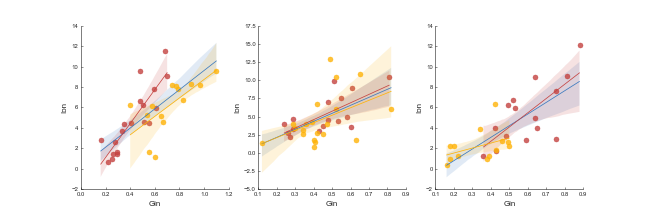

In [77]:
fig, axs = plt.subplots(1,3, figsize=(9,3))
for ax,age in zip(axs,ageOrder):
    h = data.loc[(data['AgeGroup']==age)]
    sns.regplot(data=h, x="Gin", y='Ion', scatter=False, ax=ax)
    for g in genotypeOrder:
        hh = data.loc[(data['AgeGroup']==age)&(data['Genotype']==g)]
        sns.regplot(data=hh, x="Gin", y='Ion', scatter=True, ax=ax)
    formula = 'Q("Ion") ~ Gin * C(Genotype)'  # ANCOVA formula
    lm = smf.ols(formula, h)
    fit = lm.fit()
    display(md(f" - **{age}**"))
    display(fit.summary())

## Firing vs. Non-Firing

### Input conductance

In [78]:
prop = 'Gin'
units = prop_units[prop]
precision = '.2f'
full = ''

out = compare_WT_SOD(data.loc[data['Genotype']=='SOD1'].pivot(columns='RepFiring',values=prop).reindex(['Firing','Non-firing'], axis=1), units, precision) 

display(md(out))

Firing: 0.49±0.22μS, N=47 vs. Non−firing: 0.38±0.20μS, N=6; *g*=−0.54 95%CI[−1.11–0.50]; *t*(51)=1.36, *p*=0.22

### PIC Amp

In [79]:
prop = 'PIC Amp'
units = prop_units[prop]
precision = '.2f'
full = ''

out = compare_WT_SOD(data.loc[data['Genotype']=='SOD1'].pivot(columns='RepFiring',values=prop).reindex(['Firing','Non-firing'], axis=1), units, precision) 

display(md(out))

Firing: 4.04±3.18nA, N=47 vs. Non−firing: 0.60±0.49nA, N=6; *g*=−1.12 95%CI[−1.42–−0.86]; *t*(51)=6.81, *p*=1.3e−08

### Normalized PIC Amp

In [80]:
prop = 'PIC/Gin'
units = prop_units[prop]
precision = '.2f'
full = ''

out = compare_WT_SOD(data.loc[data['Genotype']=='SOD1'].pivot(columns='RepFiring',values=prop).reindex(['Firing','Non-firing'], axis=1), units, precision) 

display(md(out))

Firing: 7.80±4.79nA/μS, N=47 vs. Non−firing: 1.91±1.82nA/μS, N=6; *g*=−1.27 95%CI[−1.65–−0.80]; *t*(51)=5.77, *p*=2.6e−05

### Age

In [81]:
prop = 'MouseAge'
units = 'days'
precision = '.0f'
full = ''

out = compare_WT_SOD(data.loc[data['RepFiring']=='Non-firing'].pivot(columns='Genotype',values=prop).reindex(genotypeOrder, axis=1), units, precision) 

display(md(out))

WT: 100±16days, N=7 vs. SOD1: 75±23days, N=6; *g*=−1.20 95%CI[−2.06–0.01]; *t*(11)=2.24, *p*=0.053

limit to the top {{N}} effect sizes at P30–60

# Figures

Figures must be submitted as separate files in TIFF or EPS format and be submitted at the size they are to appear: 1 column (maximum width 8.5 cm), 1.5 columns (maximum width 11.6 cm) or 2 columns (maximum width 17.6 cm). They should be the smallest size that will convey the essential scientific information.

In [82]:
mm2in = lambda x: x/25.4

In [83]:
plt.style.reload_library()
sns.set()
plt.style.use('default')

In [84]:
def draw_param_vs_time(ax, df, param, xlabel='Mouse age (days)', ylabel=None, label=None, showLegend=True):
    ax.set_xlim(25,130)
    for g,c,m in zip(genotypeOrder,[my_palette['WT_P60–90'], my_palette['SOD1_P60–90']],['s','D']):
        d = df[(df['Genotype']==g)]
        sns.regplot(data=d, x='MouseAge', y=param, ax=ax, color=c, marker=m,
                    scatter=True, scatter_kws=dict(s=4**2, edgecolor='gray', linewidth=0.5, clip_on=False),
                    fit_reg=True, label=g, line_kws={'lw':2, 'zorder':-1}, truncate=False)
    sns.despine(ax=ax, offset=4)
    if showLegend:
        ax.legend(title='Genotype', loc='upper right', bbox_to_anchor=(1,1.1))
    ax.set_xlabel(xlabel)
    ylabel = param if ylabel is None else ylabel
    ax.set_ylabel(ylabel)
    if label is not None:
        ax.annotate(label, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

    return ax

## Figure 1

In [85]:
plt.style.use(['default','seaborn-ticks','MM-paper'])

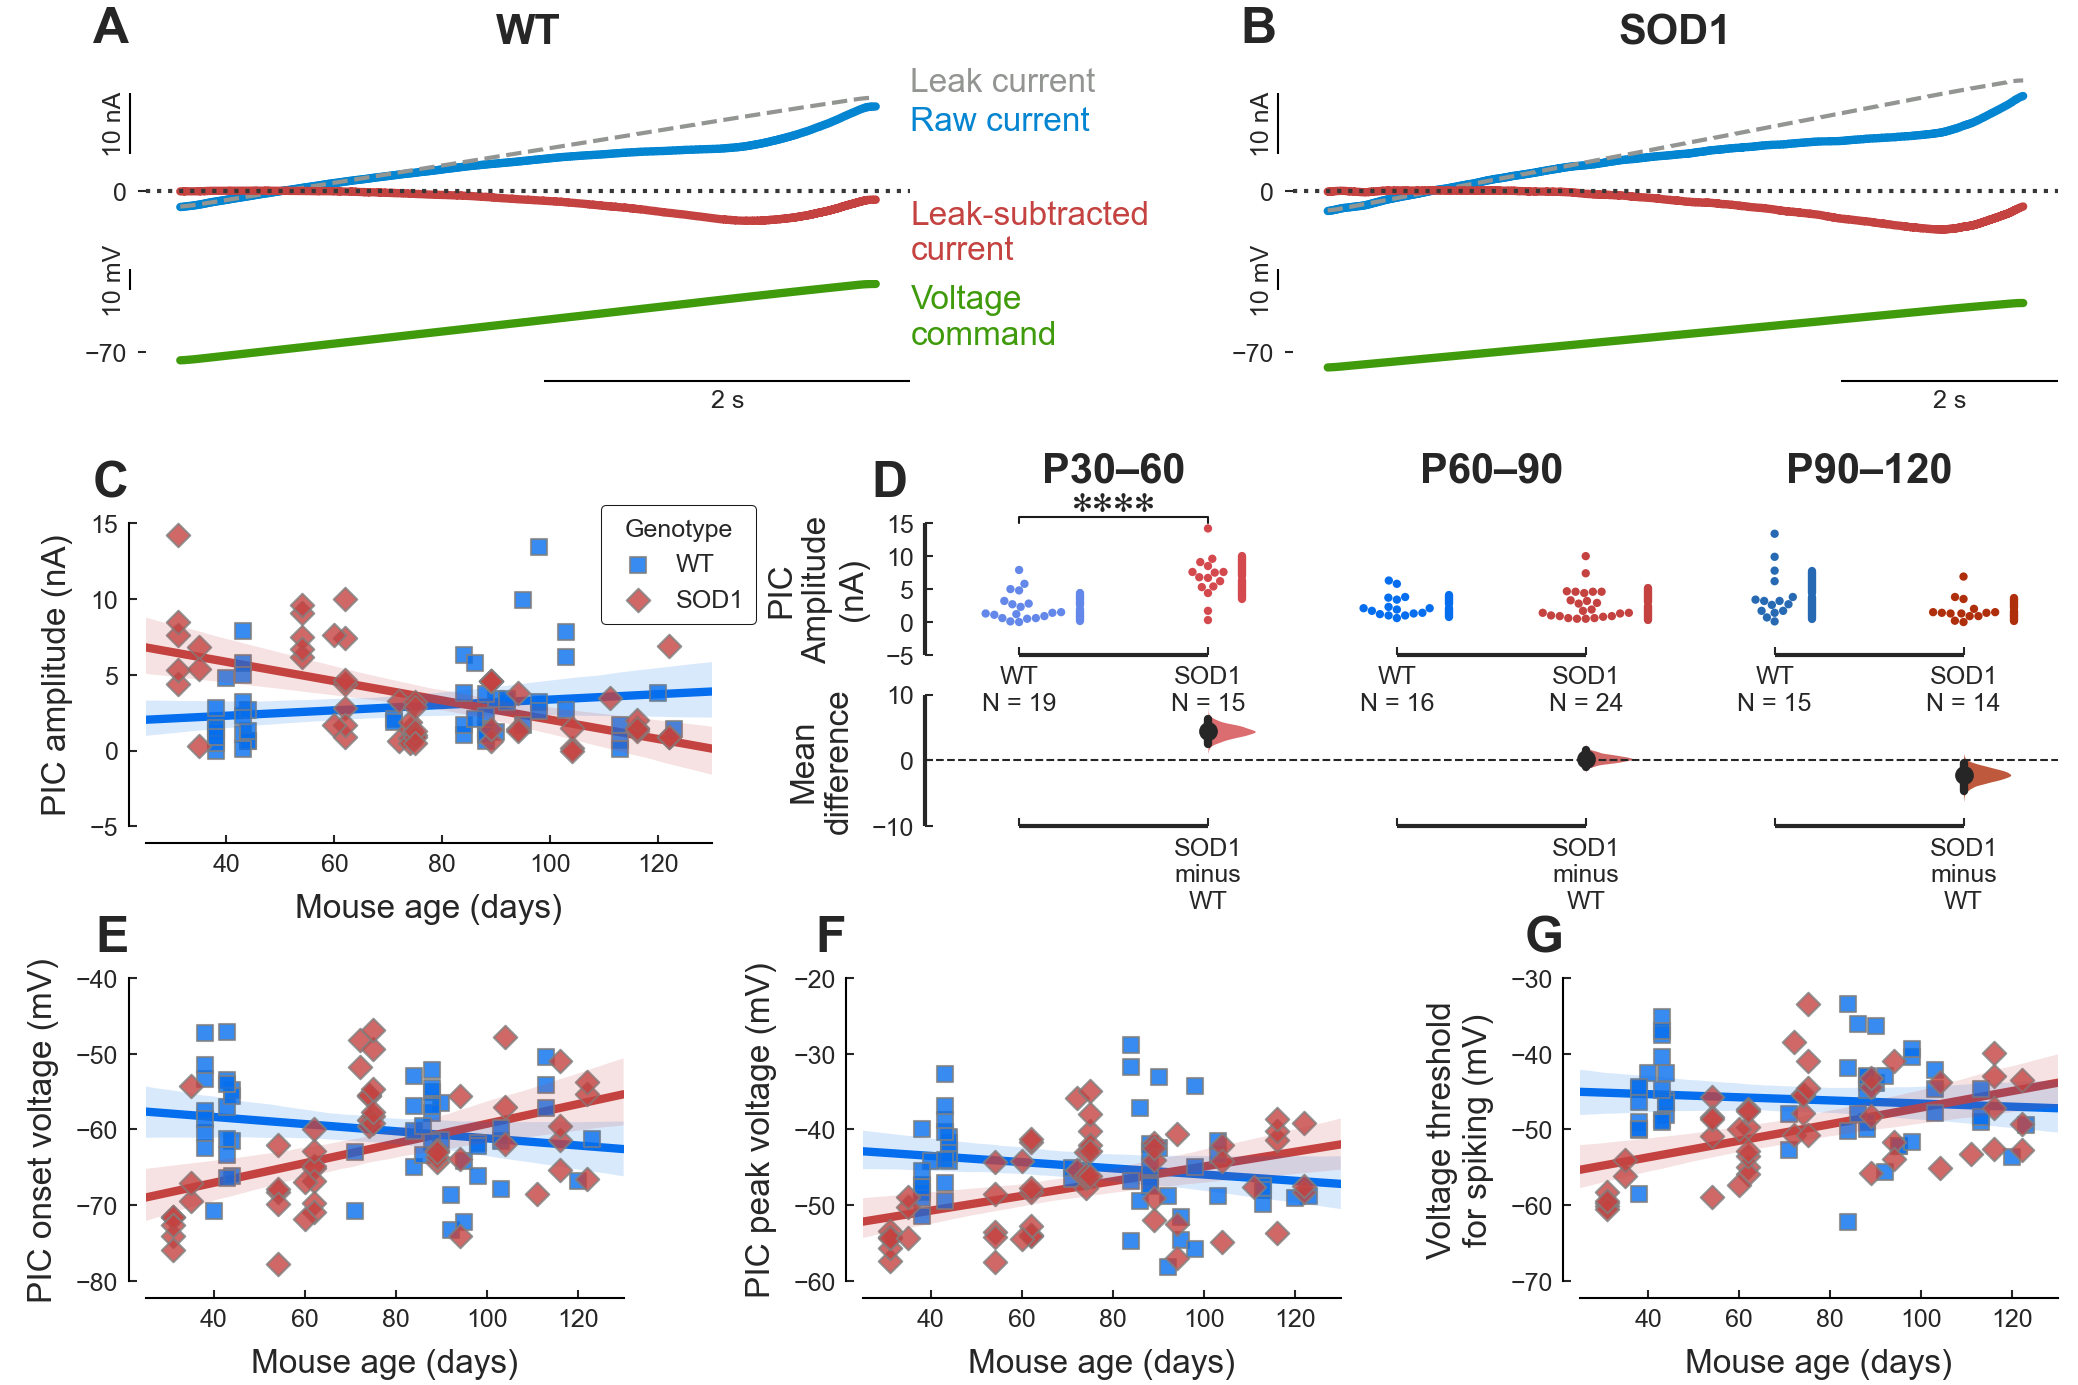

In [86]:
fig = plt.figure(figsize=(mm2in(176),mm2in(2/3*176)), dpi=300)

gs0 = gridspec.GridSpec(3,1, hspace=0.5, figure=fig)
gsTraces = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs0[0], height_ratios=[2,1], wspace=0.5)
gsPICAmp = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[1], width_ratios=[1,2], wspace=0.25)
gsPICOthers = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs0[2], wspace=0.5)

ax3 = fig.add_subplot(gsPICAmp[0])
ax4 = fig.add_subplot(gsPICAmp[1], sharey=ax3)
ax5 = fig.add_subplot(gsPICOthers[0])
ax6 = fig.add_subplot(gsPICOthers[1])
ax7 = fig.add_subplot(gsPICOthers[2])

###
### Example traces
###

ageGroup = 'P30-60'
axI = None
axV = None

LeakColor = 'xkcd:grey'
LeakSubColor = 'xkcd:reddish'
BaseLineColor = 'xkcd:dark grey'
with plt.style.context('MM-traces'):
    for i,(g,l )in enumerate(zip(['WT','SOD1'],['A','B'])):
        ###
        ### VCRamp trace
        ###
        axI = fig.add_subplot(gsTraces[0,i], sharey=axI)
        axV = fig.add_subplot(gsTraces[1,i], sharey=axV, sharex=axI)
        f = f'{g}_{ageGroup}_IVCurve.csv'
        df = pd.read_csv(f)
        axI.plot(df['Time'],df['Raw'], label='Raw current', color=Im_color, lw=2)
        axI.plot(df['Time'],df['Leak'], label='Leak current', ls='--', color=LeakColor, lw=1)
        axI.plot(df['Time'],df['Leak-sub'], label='Leak-subtracted\ncurrent', color=LeakSubColor, lw=2)
        axI.axhline(0, ls=':', color=BaseLineColor, lw=1)
        axV.plot(df['Time'], df['Vm'], color=Vm_color, label='Voltage command', lw=2)
        axI.set_ylim(-10,20)
        axI.set_xticks([])
        axI.set_yticks([0])
        axV.set_yticks([-70])
        
        axI.set_title(g)

        ax=axI
        vbar = VSizeBar(ax.transData,
                10,
                "10 nA",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.7),
                bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
        ax.add_artist(vbar)
        ax=axV
        vbar = VSizeBar(ax.transData,
                10,
                "10 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 1),
                bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
        ax.add_artist(vbar)
        tbar = HSizeBar(ax.transData,
                         2,
                         '2 s',
                         loc='upper right',
                         pad=0, borderpad=0, sep=2,
                         frameon=False,
                         bbox_to_anchor=(1, -0.1),
                         bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
        ax.add_artist(tbar)
        
        if axI.is_first_col():
            axI.annotate('Leak current', xy=(1,df['Leak'].iloc[-1]), xycoords=('axes fraction', 'data'),
                         xytext=(0,0), textcoords='offset points',
                         fontsize=plt.rcParams['axes.labelsize'], ha='left', va='bottom', color=LeakColor)
            axI.annotate('Raw current', xy=(1,df['Raw'].iloc[-1]), xycoords=('axes fraction', 'data'),
                         xytext=(0,0), textcoords='offset points',
                         fontsize=plt.rcParams['axes.labelsize'], ha='left', va='top', color=Im_color)
            axI.annotate('Leak-subtracted\ncurrent', xy=(1,df['Leak-sub'].iloc[-1]), xycoords=('axes fraction', 'data'),
                         xytext=(0,0), textcoords='offset points',
                         fontsize=plt.rcParams['axes.labelsize'], ha='left', va='top', color=LeakSubColor)
            axV.annotate('Voltage\ncommand', xy=(1,df['Vm'].iloc[-1]), xycoords=('axes fraction', 'data'),
                         xytext=(0,0), textcoords='offset points',
                         fontsize=plt.rcParams['axes.labelsize'], ha='left', va='top', color=Vm_color)
        
        axI.annotate(l, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
            
            
## Adjust plot
##
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.95, bottom=0.075, left=0.07, right=0.99)
##
##
##





###
### PIC Amp vs. age
###
param = 'PIC Amp'
ax = ax3
draw_param_vs_time(ax=ax, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='C')
ax.legend(title='Genotype', loc='upper right', bbox_to_anchor=(1.1,1.1))


###
### Cummings plot
###
fig = mean_diffs['PIC Amp'].plot(ax=ax4, 
                         swarm_label='PIC\nAmplitude\n(nA)', 
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=2,
                         es_marker_size=4,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False)
                        );
ax4.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax4.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR),pval in zip(enumerate(ageOrder), grouper(ax4.get_xticks(), 2), mean_diffs['PIC Amp'].statistical_tests['pvalue_students_t']):
    ax4.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'),
                 xytext=(0,10), textcoords='offset points',
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
    if pval<0.05:
        draw_stars(x=(tickL,tickR), y=ax4.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax4, lw=0.5, c='k')
ax4.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax4.contrast_axes.get_xticklabels())])
ax4.annotate('D', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')


###
### PIC onset voltage
###
param = 'V_PIC onset'
draw_param_vs_time(ax=ax5, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='E', showLegend=False)
#ax5.legend(title='Genotype', loc='lower right', bbox_to_anchor=(1,0))

###
### PIC peak voltage
###
param = 'V_PIC peak'
draw_param_vs_time(ax=ax6, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='F', showLegend=False)
#ax5.legend(title='Genotype', loc='lower right', bbox_to_anchor=(1,0))

###
### Vth
###
param = 'Vth'
draw_param_vs_time(ax=ax7, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='G', showLegend=False)
#ax5.legend(title='Genotype', loc='lower right', bbox_to_anchor=(1,0))

plt.savefig('./Figure 1.png')
plt.savefig('./Figure 1.tiff', dpi=600)
plt.savefig('./Figure 1.pdf')
plt.show()

## Figure 2

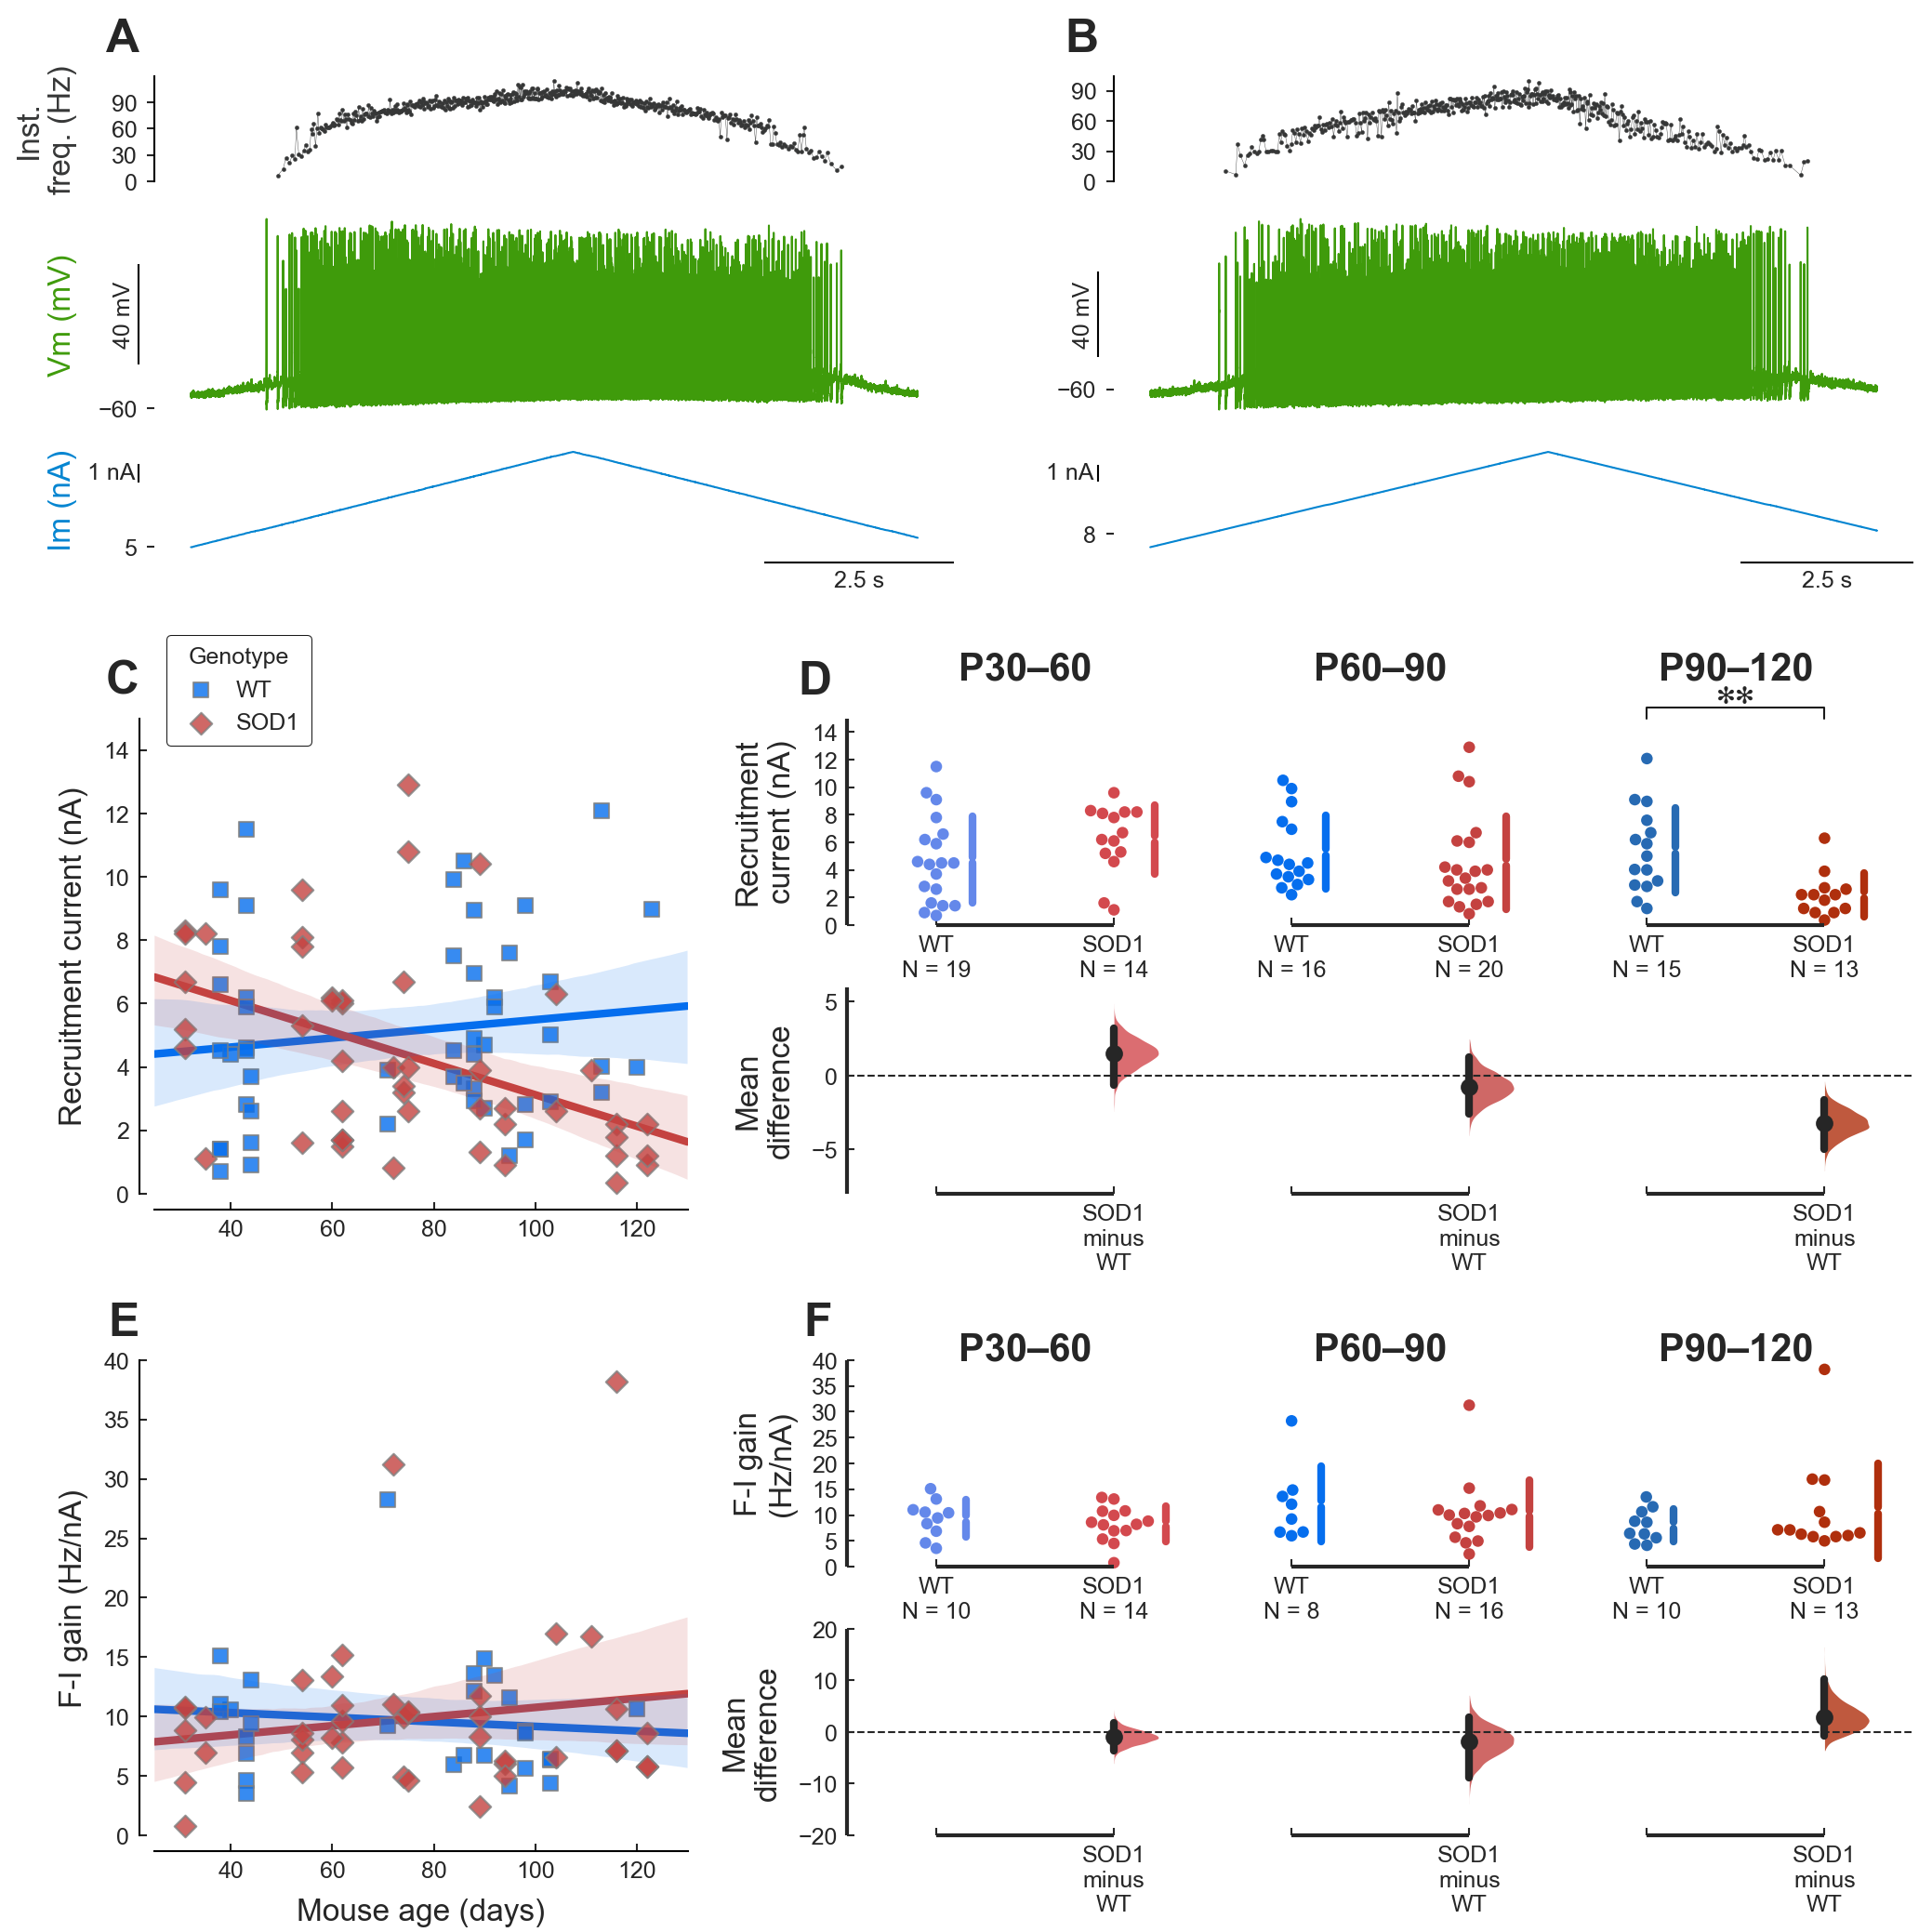

In [87]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(mm2in(176),mm2in(176)), dpi=300)

gs0 = gridspec.GridSpec(3,2, width_ratios=[1,2], figure=fig, hspace=0.35)
gs1 = gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec=gs0[0,:], height_ratios=[1,2,1])


ageGroup = 'P30-60'
FreqColor = 'xkcd:dark grey'
with plt.style.context('MM-traces'):
    for i,(g,l) in enumerate(zip(['WT','SOD1'],['A','B'])):
        axFreq = fig.add_subplot(gs1[0,i])
        axVRamp = fig.add_subplot(gs1[1,i], sharex=axFreq)
        axIRamp = fig.add_subplot(gs1[2,i], sharex=axFreq)

        f = f'{g}_{ageGroup}_traces.txt'
        df = pd.read_csv(f, sep='\t')
        axIRamp.plot(df['Time'], df['2 Im'], color=Im_color, label='Im')
        axVRamp.plot(df['Time'], df['1 Vm'], color=Vm_color, label='Vm')
        axIRamp.set_xticks([])
        axIRamp.set_yticks([np.ceil(df["2 Im"].min())])
        axVRamp.set_yticks([np.ceil(df["1 Vm"].min()/10)*10])

        ax=axIRamp
        vbar = VSizeBar(ax.transData,
                1,
                "1 nA",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.75),
                bbox_transform=ax.transAxes,textprops=dict(fontsize=6, rotation=0))
        ax.add_artist(vbar)
        ax=axVRamp
        vbar = VSizeBar(ax.transData,
                40,
                "40 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
        ax.add_artist(vbar)
        ax=axIRamp
        tbar = HSizeBar(ax.transData,
                         2.5,
                         '2.5 s',
                         loc='upper right',
                         pad=0, borderpad=0, sep=2,
                         frameon=False,
                         bbox_to_anchor=(1, -0.1),
                         bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
        ax.add_artist(tbar)

        f = f'{g}_{ageGroup}_freq.txt'
        f = np.loadtxt(f, skiprows=16)
        axFreq.plot(f[1:],1/np.diff(f),'o-', color=FreqColor, ms=1, mew=0.1, lw=0.1, label='Instantaneous\nfrequency')
        sns.despine(ax=axFreq, left=False, bottom=True)
        axFreq.set_ylim(bottom=0)
        from matplotlib.ticker import MaxNLocator
        axFreq.yaxis.set_major_locator(MaxNLocator(4))
        
        axFreq.annotate(l, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

        if axFreq.is_first_col():
            for ax,label,c in zip([axFreq, axVRamp, axIRamp],
                                  ['Inst.\nfreq. (Hz)', 'Vm (mV)', 'Im (nA)'],
                                  [FreqColor, Vm_color, Im_color]):
                ax.annotate(label, xy=(0,0.5), xycoords='axes fraction',
                            xytext=(-20,0), textcoords='offset points',
                            fontsize=plt.rcParams['axes.labelsize'], color=c, rotation=90, ha='center', va='bottom', rotation_mode='anchor')
            
ax1 = fig.add_subplot(gs0[1,0])
ax3 = fig.add_subplot(gs0[1,1], sharey=ax1)
ax2 = fig.add_subplot(gs0[2,0], sharex=ax1)
ax4 = fig.add_subplot(gs0[2,1], sharey=ax2)


###
### adjust figure subplots
###
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.96, bottom=0.05, left=0.08, right=0.99)
###
###
###


ax = ax1
param = 'Ion'
draw_param_vs_time(ax=ax, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='C', showLegend=True)
ax.legend(title='Genotype', loc='upper left', bbox_to_anchor=(0,1.2))
ax1.set_xlabel('')

ax = ax3
dabest_obj = mean_diffs['Ion']
swarm_label = 'Recruitment\ncurrent (nA)'
contrast_label = 'Mean\ndifference'
ylim = (0,15) # for pretty ticks
panel_number = 'D'
dabest_obj.plot(ax=ax, 
                         swarm_label=swarm_label,
                         contrast_label=contrast_label,
                         custom_palette=my_palette,
                         raw_marker_size=3,
                         es_marker_size=4,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5),
                         swarm_ylim=ylim,
                         swarmplot_kwargs={'clip_on':False}
                        );
ax.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR),pval in zip(enumerate(ageOrder), grouper(ax.get_xticks(), 2), dabest_obj.statistical_tests['pvalue_students_t']):
    ax.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'),
                xytext=(0,10), textcoords='offset points',
                fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
    if pval<0.05:
        draw_stars(x=(tickL,tickR), y=ax.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax, lw=0.5, c='k')
ax.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' 
                                  for i,label in enumerate(ax.contrast_axes.get_xticklabels())])
ax.annotate(panel_number, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')


ax = ax2
param = 'Gain_Asc'
draw_param_vs_time(ax=ax, df=data, param=param, ylabel='F-I gain (Hz/nA)', label='E', showLegend=False)



ax = ax4
dabest_obj = mean_diffs['Gain_Asc']
swarm_label = 'F-I gain\n(Hz/nA)'
contrast_label = 'Mean\ndifference'
ylim = (0,40) # for pretty ticks
panel_number = 'F'
dabest_obj.plot(ax=ax, 
                         swarm_label=swarm_label,
                         contrast_label=contrast_label,
                         custom_palette=my_palette,
                         raw_marker_size=3,
                         es_marker_size=4,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5),
                         swarm_ylim=ylim,
                         swarmplot_kwargs={'clip_on':False}
                        );
ax.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR) in zip(enumerate(ageOrder), grouper(ax.get_xticks(), 2)):
    ax.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'), 
                 fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
ax.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' 
                                  for i,label in enumerate(ax.contrast_axes.get_xticklabels())])
ax.annotate(panel_number, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

plt.savefig('./Figure 2.png')
plt.savefig('./Figure 2.tiff', dpi=600)
plt.savefig('./Figure 2.pdf')
plt.show()

## Figure 3

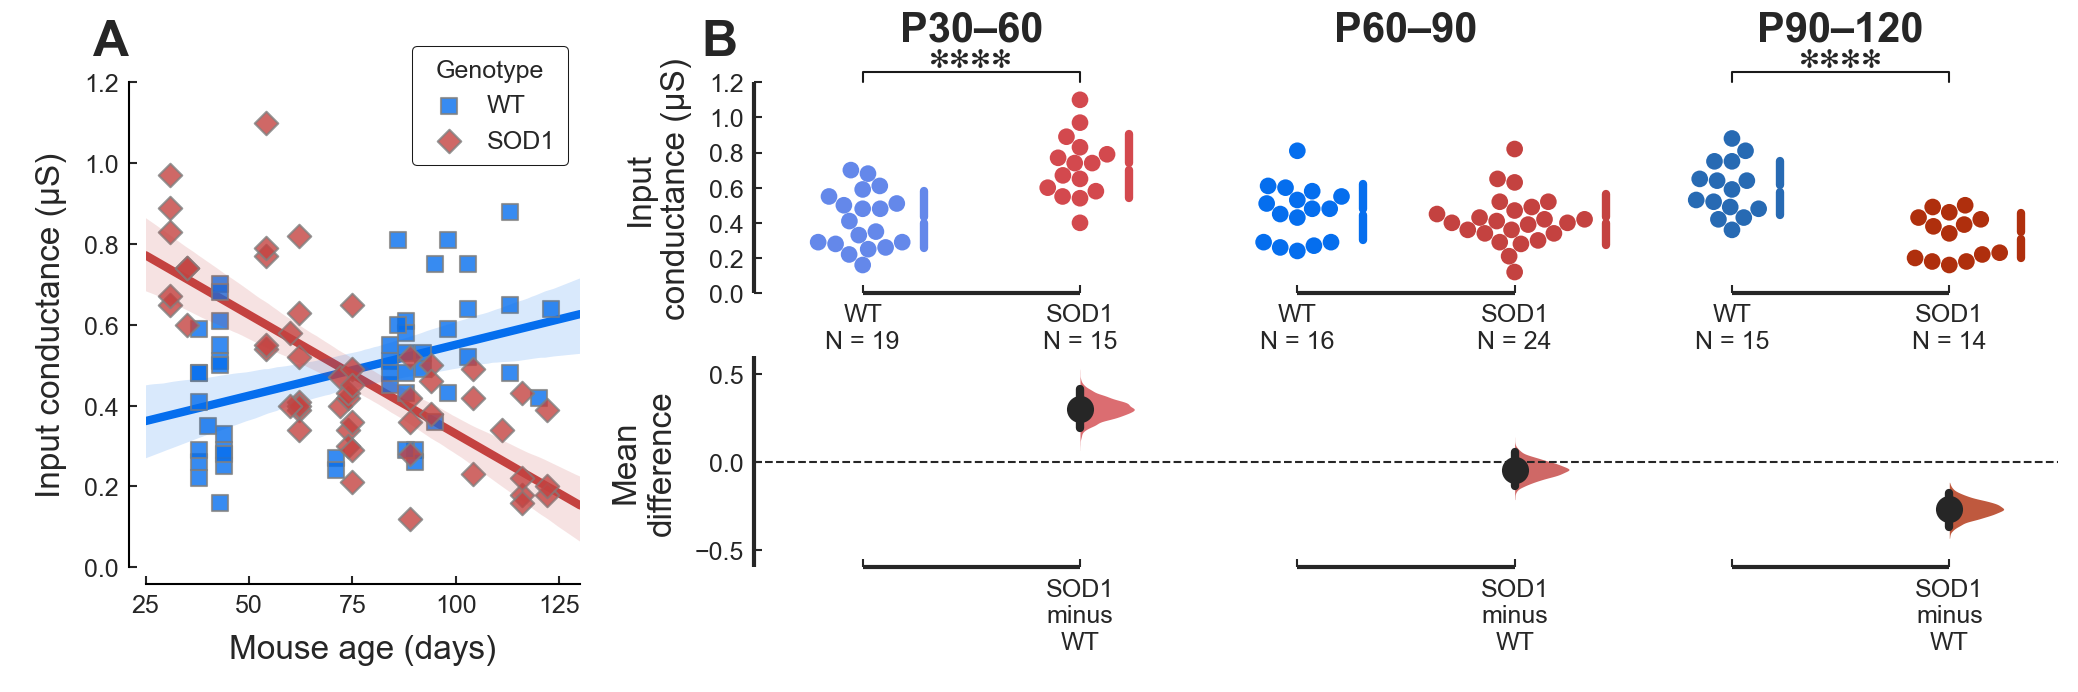

In [88]:

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(mm2in(176),mm2in(176/3)), 
                                           sharey='row', 
                                           gridspec_kw={'width_ratios':[1,3]},
                                           dpi=300
                                          )

###
### adjust figure subplots
###
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.88, bottom=0.18, left=0.07, right=0.99)
###
###
###


param = 'Gin'
draw_param_vs_time(ax=ax1, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='A', showLegend=True)


ax=ax2
dabest_obj = mean_diffs['Gin']
dabest_obj.plot(ax=ax2, 
                         swarm_label='Input\nconductance (μS)',
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5)
                        );
ax2.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax2.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR),pval in zip(enumerate(ageOrder), grouper(ax.get_xticks(), 2), dabest_obj.statistical_tests['pvalue_students_t']):
    ax.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'),
                xytext=(0,10), textcoords='offset points',
                fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
    if pval<0.05:
        draw_stars(x=(tickL,tickR), y=ax.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax, lw=0.5, c='k')
ax2.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax2.contrast_axes.get_xticklabels())])
ax2.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

plt.savefig('./Figure 3.png')
plt.savefig('./Figure 3.tiff', dpi=600)
plt.savefig('./Figure 3.pdf')
plt.show()

## Figure 4

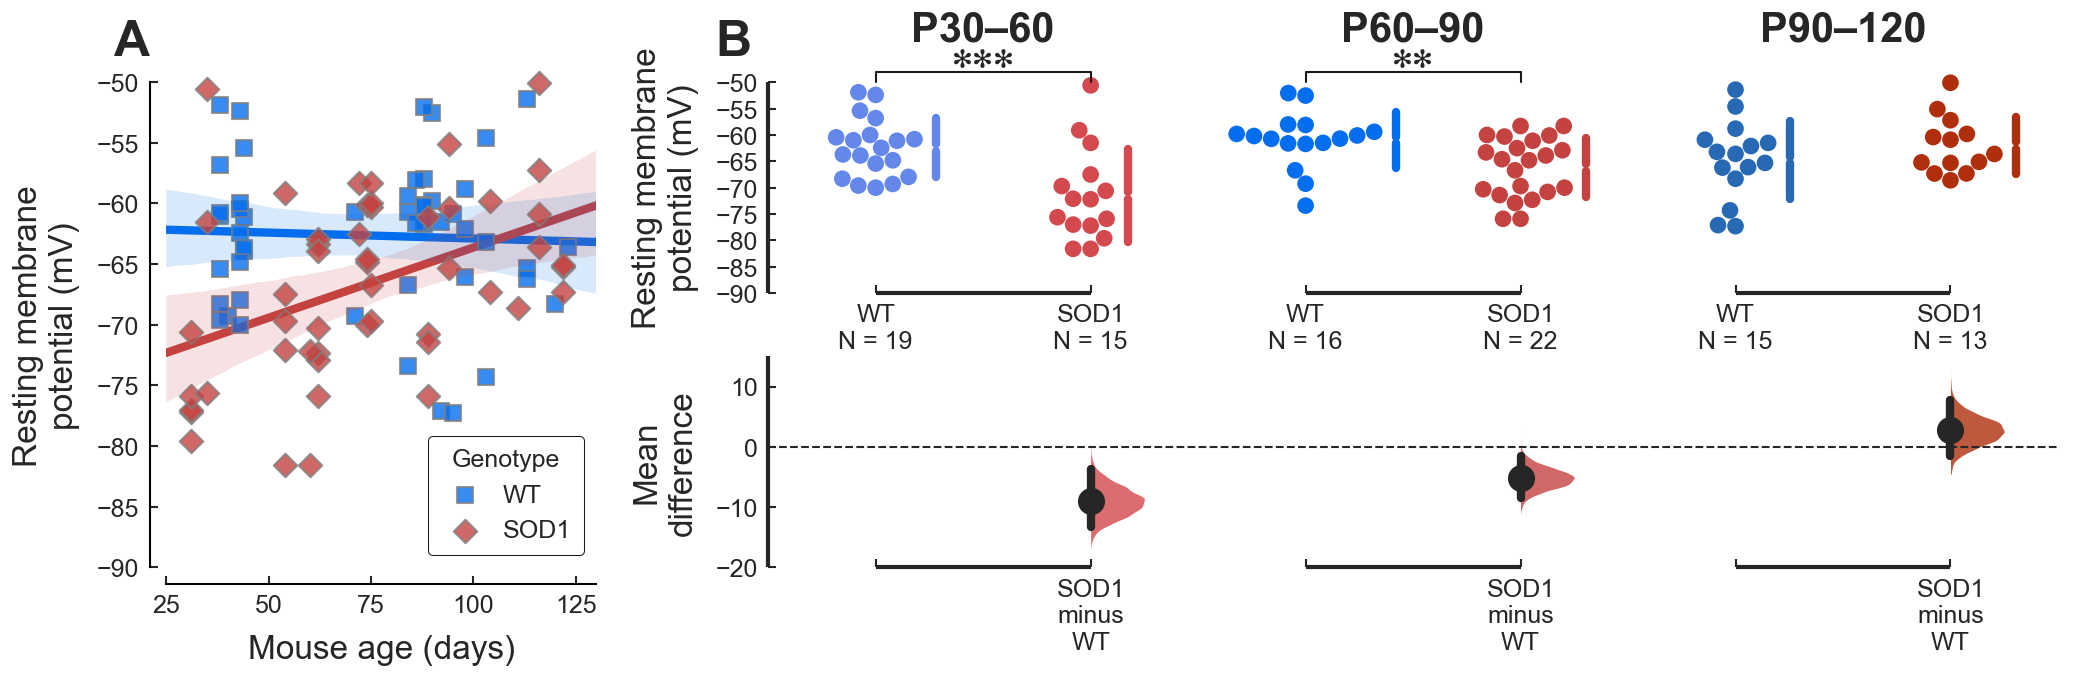

In [89]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(mm2in(176),mm2in(176/3)), 
                                           sharey='row', 
                                           gridspec_kw={'width_ratios':[1,3]},
                                           dpi=300
                                          )

###
### adjust figure subplots
###
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.88, bottom=0.18, left=0.08, right=0.99)
###
###
###

param = 'RMP'
draw_param_vs_time(ax=ax1, df=data, param=param, ylabel=f'{prop_labels[param]} ({prop_units[param]})', label='A', showLegend=True)
ax1.legend(title='Genotype', loc='lower right', bbox_to_anchor=(1,0))


ax = ax2
dabest_obj = mean_diffs['RMP']
dabest_obj.plot(ax=ax2, 
                         swarm_label='Resting membrane\npotential (mV)',
                         contrast_label='Mean\ndifference',
                         custom_palette=my_palette,
                         raw_marker_size=4,
                         es_marker_size=6,
                         swarm_desat=1,
                         group_summaries='mean_sd',
                         reflines_kwargs=dict(linestyle='--', linewidth=0.5),
                   swarm_ylim=(-90,-50),
                   swarmplot_kwargs=dict(clip_on=False)
                        );

ax2.set_xticklabels([
    '\n'.join([
        label,tick.get_text().split('\n')[-1]]) for tick,label in zip(ax2.get_xticklabels(), 
                                                                      itertools.cycle(genotypeOrder))])
for (i,label),(tickL,tickR),pval in zip(enumerate(ageOrder), grouper(ax.get_xticks(), 2), dabest_obj.statistical_tests['pvalue_students_t']):
    ax.annotate(label, xy=(tickL+(tickR-tickL)/2,1), xycoords=('data','axes fraction'),
                xytext=(0,10), textcoords='offset points',
                fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
    if pval<0.05:
        draw_stars(x=(tickL,tickR), y=ax.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax, lw=0.5, c='k')
ax2.contrast_axes.set_xticklabels(['\nminus\n'.join(genotypeOrder[::-1]) if i%2 else '' for i,label in enumerate(ax2.contrast_axes.get_xticklabels())])
ax2.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')


plt.savefig('./Figure 4.png')
plt.savefig('./Figure 4.tiff', dpi=600)
plt.savefig('./Figure 4.pdf')
plt.show()

## Figure 5

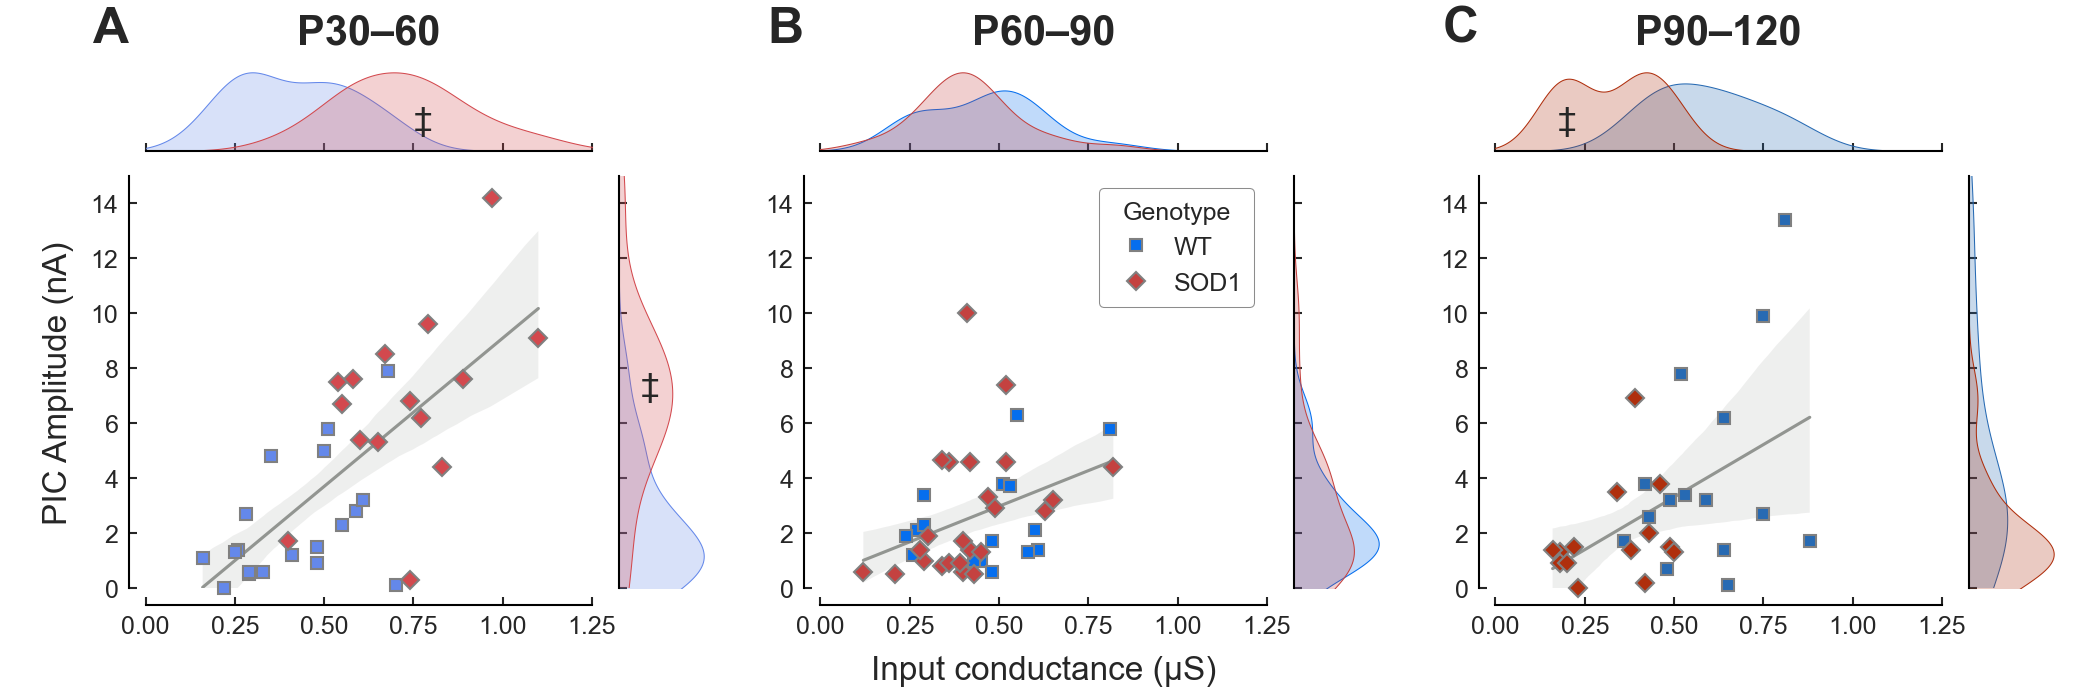

In [90]:
W = 2
sp=.1
#fig = plt.figure(figsize=(W*(3+3/6),W*(1+1/6)+1.5*W), dpi=300)
fig = plt.figure(figsize=(mm2in(176),mm2in(1/3*176)), dpi=300)
gs1 = gridspec.GridSpec(1,3, figure=fig, hspace=3*sp)
gs00 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs1[0], height_ratios=[1,5], width_ratios=[5,1], wspace=sp, hspace=sp)
gs01 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs1[1], height_ratios=[1,5], width_ratios=[5,1], wspace=sp, hspace=sp)
gs02 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gs1[2], height_ratios=[1,5], width_ratios=[5,1], wspace=sp, hspace=sp)


young_main = fig.add_subplot(gs00[1,0])
young_top = fig.add_subplot(gs00[0,0], sharex=young_main)
young_bottom = fig.add_subplot(gs00[1,1], sharey=young_main)

med_main = fig.add_subplot(gs01[1,0], sharex=young_main, sharey=young_main)
med_top = fig.add_subplot(gs01[0,0], sharex=med_main)
med_bottom = fig.add_subplot(gs01[1,1], sharey=med_main)

old_main = fig.add_subplot(gs02[1,0], sharex=young_main, sharey=young_main)
old_top = fig.add_subplot(gs02[0,0], sharex=old_main)
old_bottom = fig.add_subplot(gs02[1,1], sharey=old_main)


###
### adjust figure subplots
###
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.07, right=0.99)
###
###
###


color_iter = iter(my_palette.values())
markers = ['s','D']
for (g,temp),(main,top,bottom),label in zip(data.groupby('AgeGroup'),
                                            ((young_main,young_top,young_bottom),
                                             (med_main, med_top, med_bottom),
                                             (old_main, old_top, old_bottom)),
                                            ('A','B','C')):
    
    sns.regplot(data=temp, x='Gin', y='PIC Amp', scatter=False, ax=main, line_kws={'color':'xkcd:grey'})
    for G,m in zip(genotypeOrder,markers):
        sub = temp.loc[temp['Genotype']==G]
        c = next(color_iter)
        main.plot(sub['Gin'], sub['PIC Amp'], color=c, marker=m, lw=0, label=G, ms=3, clip_on=False, mec='gray', mew=0.5)

        sns.kdeplot(x=sub['Gin'], ax=top, fill=True, color=c)
        sns.kdeplot(y=sub['PIC Amp'], ax=bottom, fill=True, color=c)

    top.set_title(g, fontfamily='Arial', ha='center', fontsize=10, fontweight='bold')
    sns.despine(ax=main, offset=4)
    main.set_xlabel('')
    main.set_ylabel('')
    main.set_xlim(0,1.25)
    main.set_ylim(0,15) # too much whitespace
    top.annotate(label, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')



    sns.despine(ax=top, offset=0, left=True)
    top.spines['left'].set_position(('outward', 4))
    sns.despine(ax=bottom, offset=0, bottom=True)
    bottom.spines['bottom'].set_position(('outward', 4))
    top.set_xlabel('')
    top.set_ylabel('')
    bottom.set_xlabel('')
    bottom.set_ylabel('')
    plt.setp(top.get_xticklabels(), visible=False)
    plt.setp(bottom.get_yticklabels(), visible=False)
    top.set_yticks([])
    bottom.set_xticks([])

young_main.set_ylabel('PIC Amplitude (nA)')
med_main.set_xlabel('Input conductance (μS)')
med_main.legend(title='Genotype', loc='upper right', framealpha=0.5)

young_top.annotate('‡', xy=(0.75,0.25), xycoords=('data','axes fraction'), fontfamily='Arial Unicode MS')
young_bottom.annotate('‡', xy=(0.25,7), xycoords=('axes fraction','data'), fontfamily='Arial Unicode MS')
old_top.annotate('‡', xy=(0.175,0.25), xycoords=('data','axes fraction'), fontfamily='Arial Unicode MS')


plt.savefig('./Figure 5.png')
plt.savefig('./Figure 5.tiff', dpi=600)
plt.savefig('./Figure 5.pdf')
plt.show()

## Figure 6

In [91]:
noFGin = dabest.load(data=data.loc[data['Genotype']=='SOD1'], idx=('Firing', 'Non-firing'), x='RepFiring', y='Gin')
noFPICAmp = dabest.load(data=data.loc[data['Genotype']=='SOD1'], idx=('Firing', 'Non-firing'), x='RepFiring', y='PIC Amp')
noFPICNormPICAmp = dabest.load(data=data.loc[data['Genotype']=='SOD1'], idx=('Firing', 'Non-firing'), x='RepFiring', y='PIC/Gin')
noFAge = dabest.load(data=data.loc[data['RepFiring']=='Non-firing'], idx=('WT', 'SOD1'), x='Genotype', y='MouseAge')

In [92]:
noFexample = pd.read_csv('./Cell692_exampleNoF.txt')

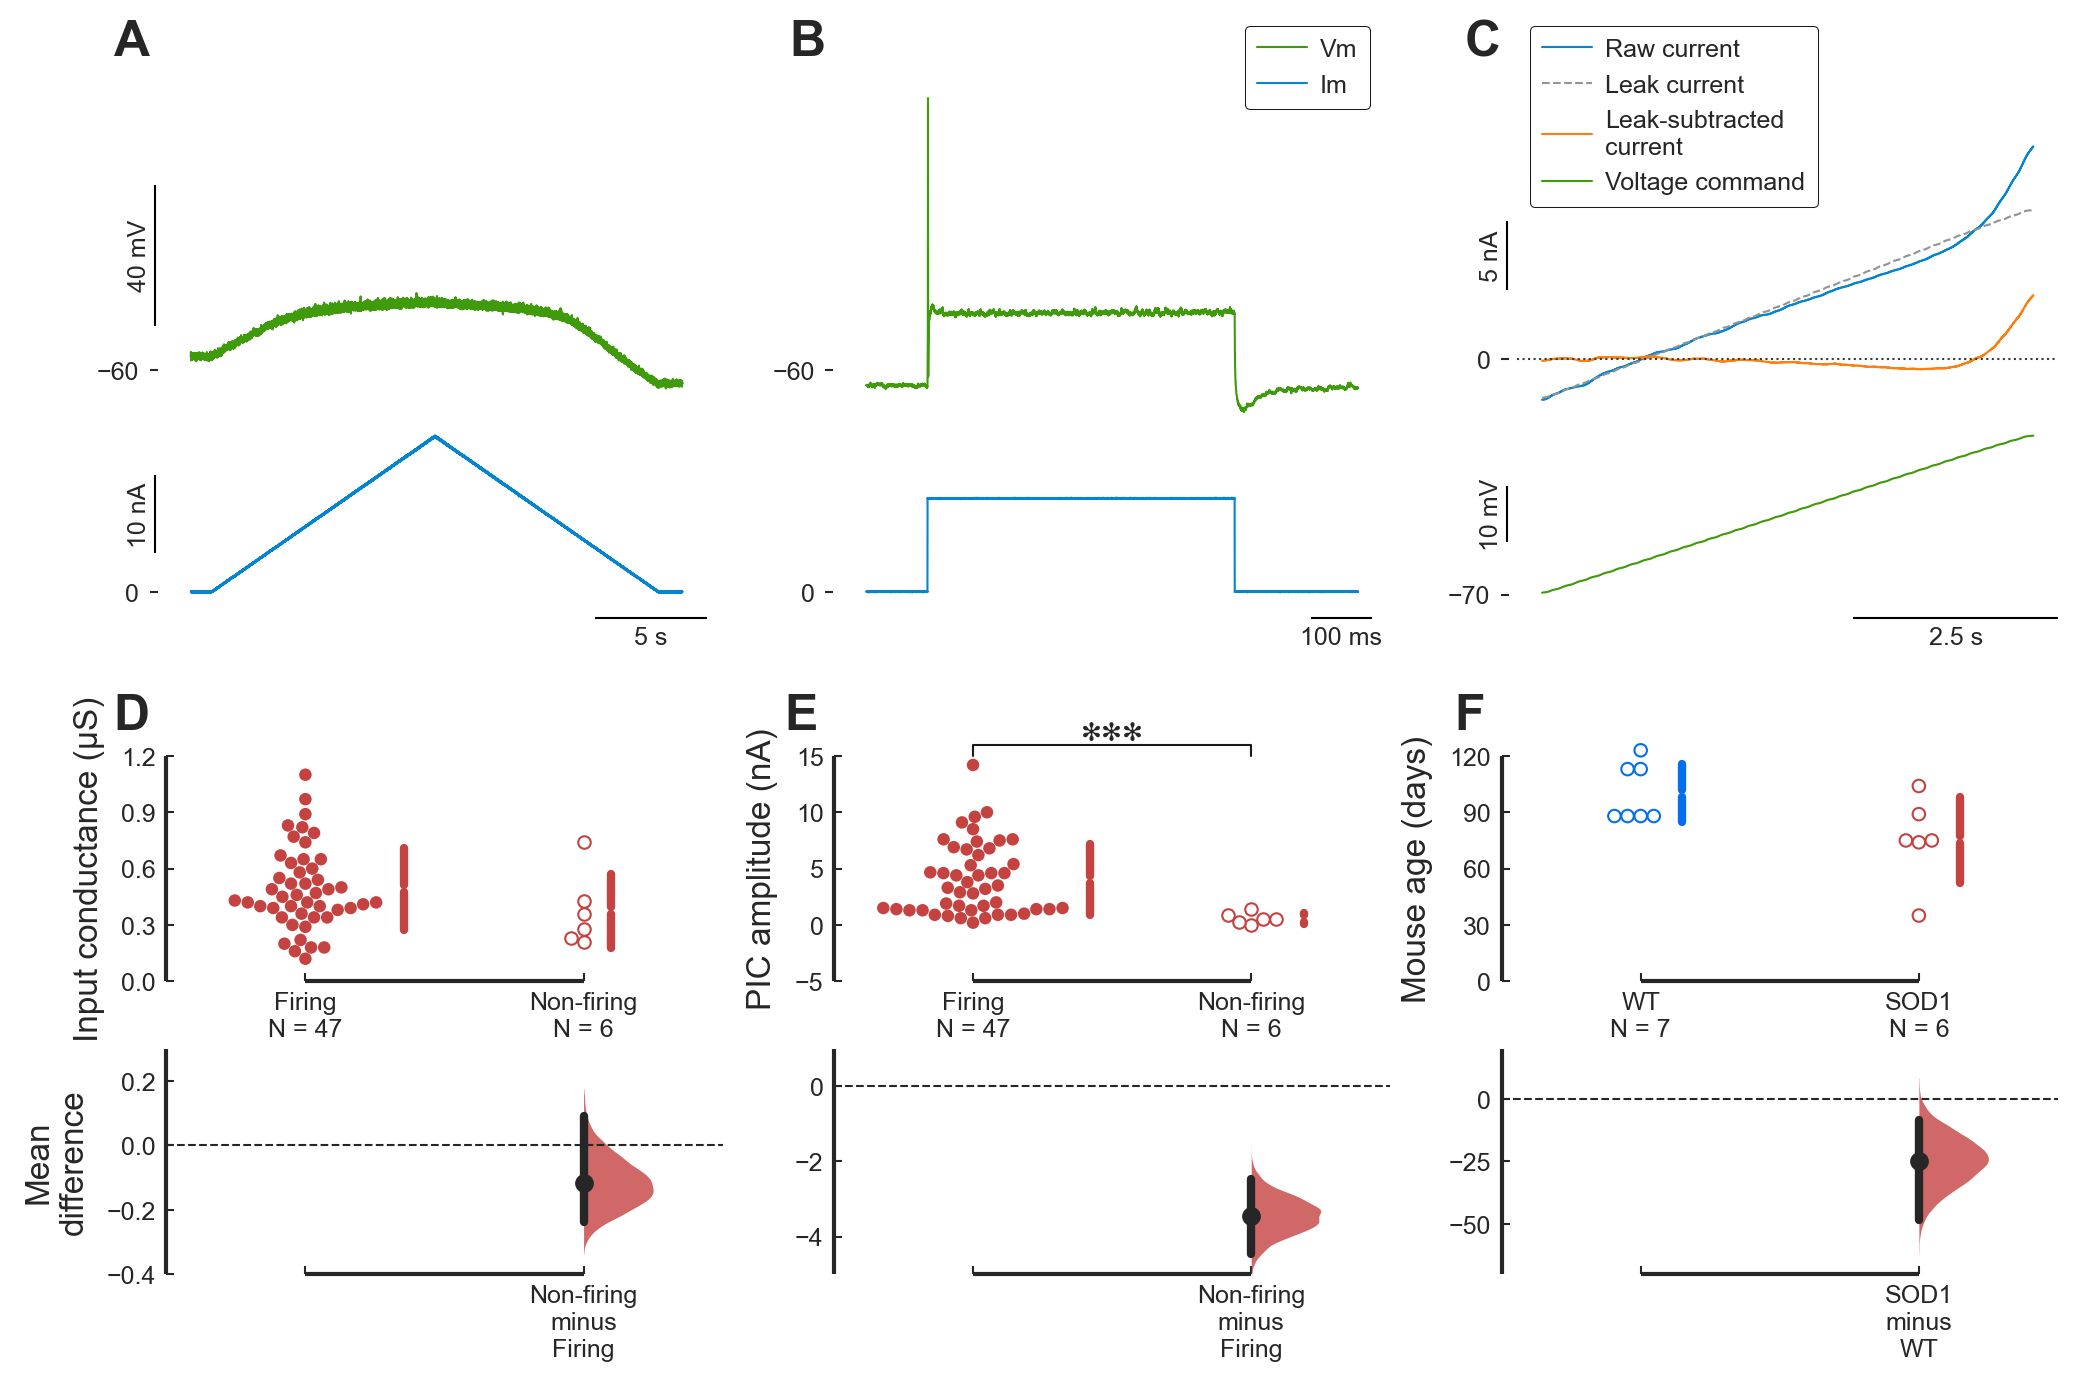

In [93]:
palette_noF = {'Firing': 'xkcd:reddish',
               'Non-firing': 'xkcd:reddish'}
palette_age = {'WT':'xkcd:cerulean blue','SOD1':'xkcd:reddish'}


fig = plt.figure(figsize=(mm2in(176),mm2in(2*176/3)), dpi=300)
gs0 = gridspec.GridSpec(2,3, figure=fig, height_ratios=[1,1], hspace=0.3)

gs00 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gs0[0,:], height_ratios=[2,1], hspace=0, wspace=0.25)
ax00 = fig.add_subplot(gs00[0,0])
ax10 = fig.add_subplot(gs00[0,1], sharey=ax00)
ax01 = fig.add_subplot(gs00[1,0])
ax11 = fig.add_subplot(gs00[1,1], sharey=ax01)
ax20 = fig.add_subplot(gs00[0,2])
ax21 = fig.add_subplot(gs00[1,2], sharex=ax20)


###
### adjust figure subplots
###
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.94, bottom=0.08, left=0.08, right=0.99)
###
###
###

ax00.plot(noFexample['CCRampTime'], noFexample['CCRampVm'], '-', c=Vm_color, label='Vm')
ax01.plot(noFexample['CCRampTime'], noFexample['CCRampIm'], '-', c=Im_color, label='Im')

ax10.plot(noFexample['PulseTime'], noFexample['PulseVm'], '-', c=Vm_color, label='Vm')
ax11.plot(noFexample['PulseTime'], noFexample['PulseIm'], '-', c=Im_color, label='Im')

axI = ax20
axV = ax21
df = noFexample
axI.plot(df['VCRampTime'],df['VCRampRaw'], label='Raw current', color=Im_color)
axI.plot(df['VCRampTime'],df['VCRampLeak'], label='Leak current', ls='--', color='xkcd:grey')
axI.plot(df['VCRampTime'],df['VCRampLeak-sub'], label='Leak-subtracted\ncurrent', color='C1')
axI.axhline(0, ls=':', color='xkcd:dark grey')
axV.plot(df['VCRampTime'], df['VCRampVm'], color=Vm_color, label='Voltage command')
axI.set_yticks([0])
axV.set_yticks([-70])

for ax in [ax00,ax01,ax10,ax11,ax20,ax21]:
    sns.despine(ax=ax, bottom=True, left=False, right=True, top=True, offset=4)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
ax00.set_yticks([-60])
#ax10.set_yticks([-60])
ax01.set_yticks([0])
#ax11.set_yticks([0])
ax00.annotate('A', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax10.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
ax20.annotate('C', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
vbar = VSizeBar(ax00.transData,
                40,
                "40 mV",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax00.transAxes,textprops=dict(fontsize=6))
ax00.add_artist(vbar)
ibar = VSizeBar(ax01.transData,
                10,
                "10 nA",
                loc='center right',
                pad=0, borderpad=0, sep=1,
                frameon=False,
                bbox_to_anchor=(-0.02, 0.5),
                bbox_transform=ax01.transAxes,textprops=dict(fontsize=6))
ax01.add_artist(ibar)
tbar1 = HSizeBar(ax01.transData,
                 5,
                 '5 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax01.transAxes,textprops=dict(fontsize=6))
ax01.add_artist(tbar1)
tbar2 = HSizeBar(ax11.transData,
                 0.1,
                 '100 ms',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax11.transAxes,textprops=dict(fontsize=6))
ax11.add_artist(tbar2)

ax=axI
vbar = VSizeBar(ax.transData,
        5,
        "5 nA",
        loc='center right',
        pad=0, borderpad=0, sep=1,
        frameon=False,
        bbox_to_anchor=(-0.02, 0.5),
        bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
ax.add_artist(vbar)
ax=axV
vbar = VSizeBar(ax.transData,
        10,
        "10 mV",
        loc='center right',
        pad=0, borderpad=0, sep=1,
        frameon=False,
        bbox_to_anchor=(-0.02, 0.5),
        bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
ax.add_artist(vbar)
tbar = HSizeBar(ax.transData,
                 2.5,
                 '2.5 s',
                 loc='upper right',
                 pad=0, borderpad=0, sep=2,
                 frameon=False,
                 bbox_to_anchor=(1, -0.1),
                 bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
ax.add_artist(tbar)

h1,l1 = axI.get_legend_handles_labels()
h2,l2 = axV.get_legend_handles_labels()
axI.legend(h1+h2,l1+l2, loc='upper left', bbox_to_anchor=(0.0,1.2))

h1,l1 = ax10.get_legend_handles_labels()
h2,l2 = ax11.get_legend_handles_labels()
ax10.legend(h1+h2,l1+l2, loc='upper right', bbox_to_anchor=(1,1.2))


ax1 = fig.add_subplot(gs0[1,0])
ax2 = fig.add_subplot(gs0[1,1])
ax3 = fig.add_subplot(gs0[1,2])

noFGin.mean_diff.plot(ax=ax1, float_contrast=False,
                     swarm_label='Input conductance (μS)', 
                     contrast_label='Mean\ndifference',
                     custom_palette=palette_noF,
                     raw_marker_size=3,
                     es_marker_size=4,
                     swarm_desat=1,
                     group_summaries='mean_sd',
                     reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False),
                     swarm_ylim=(0,1.2)); # for pretty ticks
ax1.collections[1].set_facecolor('w')
ax1.collections[1].set_edgecolor('xkcd:reddish')
ax1.collections[1].set_linewidth(0.5)
ax=ax1
dabest_obj = noFGin
pval = dabest_obj.mean_diff.statistical_tests.loc[0,'pvalue_mann_whitney']
if pval<0.05:
    draw_stars(x=(0,1), y=ax.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax, lw=0.5, c='k')
noFPICAmp.mean_diff.plot(ax=ax2, float_contrast=False,
                     swarm_label='PIC amplitude (nA)', 
                     contrast_label='',
                     custom_palette=palette_noF,
                     raw_marker_size=3,
                     es_marker_size=4,
                     swarm_desat=1,
                     group_summaries='mean_sd',
                     reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False),
                     contrast_ylim=(-5,1)); # otherwise zero-line not visible
ax2.collections[1].set_facecolor('w')
ax2.collections[1].set_edgecolor('xkcd:reddish')
ax2.collections[1].set_linewidth(0.5)
ax=ax2
dabest_obj = noFPICAmp
pval = dabest_obj.mean_diff.statistical_tests.loc[0,'pvalue_mann_whitney']
if pval<0.05:
    draw_stars(x=(0,1), y=ax.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax, lw=0.5, c='k')
noFAge.mean_diff.plot(ax=ax3, float_contrast=False,
                     swarm_label='Mouse age (days)', 
                     contrast_label='',
                     custom_palette=palette_age,
                     raw_marker_size=3,
                     es_marker_size=4,
                     swarm_desat=1,
                     group_summaries='mean_sd',
                     reflines_kwargs=dict(linestyle='--', linewidth=0.5), swarmplot_kwargs=dict(clip_on=False),
                     swarm_ylim=(0,120));

for col in ax3.collections[:2]:
    color = col.get_facecolor();
    col.set_facecolor('w')
    col.set_edgecolor(color)
    col.set_linewidth(0.5)
ax=ax3
dabest_obj = noFAge
pval = dabest_obj.mean_diff.statistical_tests.loc[0,'pvalue_mann_whitney']
if pval<0.05:
    draw_stars(x=(0,1), y=ax.get_ylim()[1], text=stars(pval), fontsize=6, ax=ax, lw=0.5, c='k')

for ax,l in zip([ax1,ax2,ax3],['D','E','F']):
    ax.annotate(l, xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.contrast_axes.yaxis.set_major_locator(ticker.MaxNLocator(4))

    
plt.savefig('./Figure 6.png')
plt.savefig('./Figure 6.tiff', dpi=600)
plt.savefig('./Figure 6.pdf')
plt.show()

## Figure 7

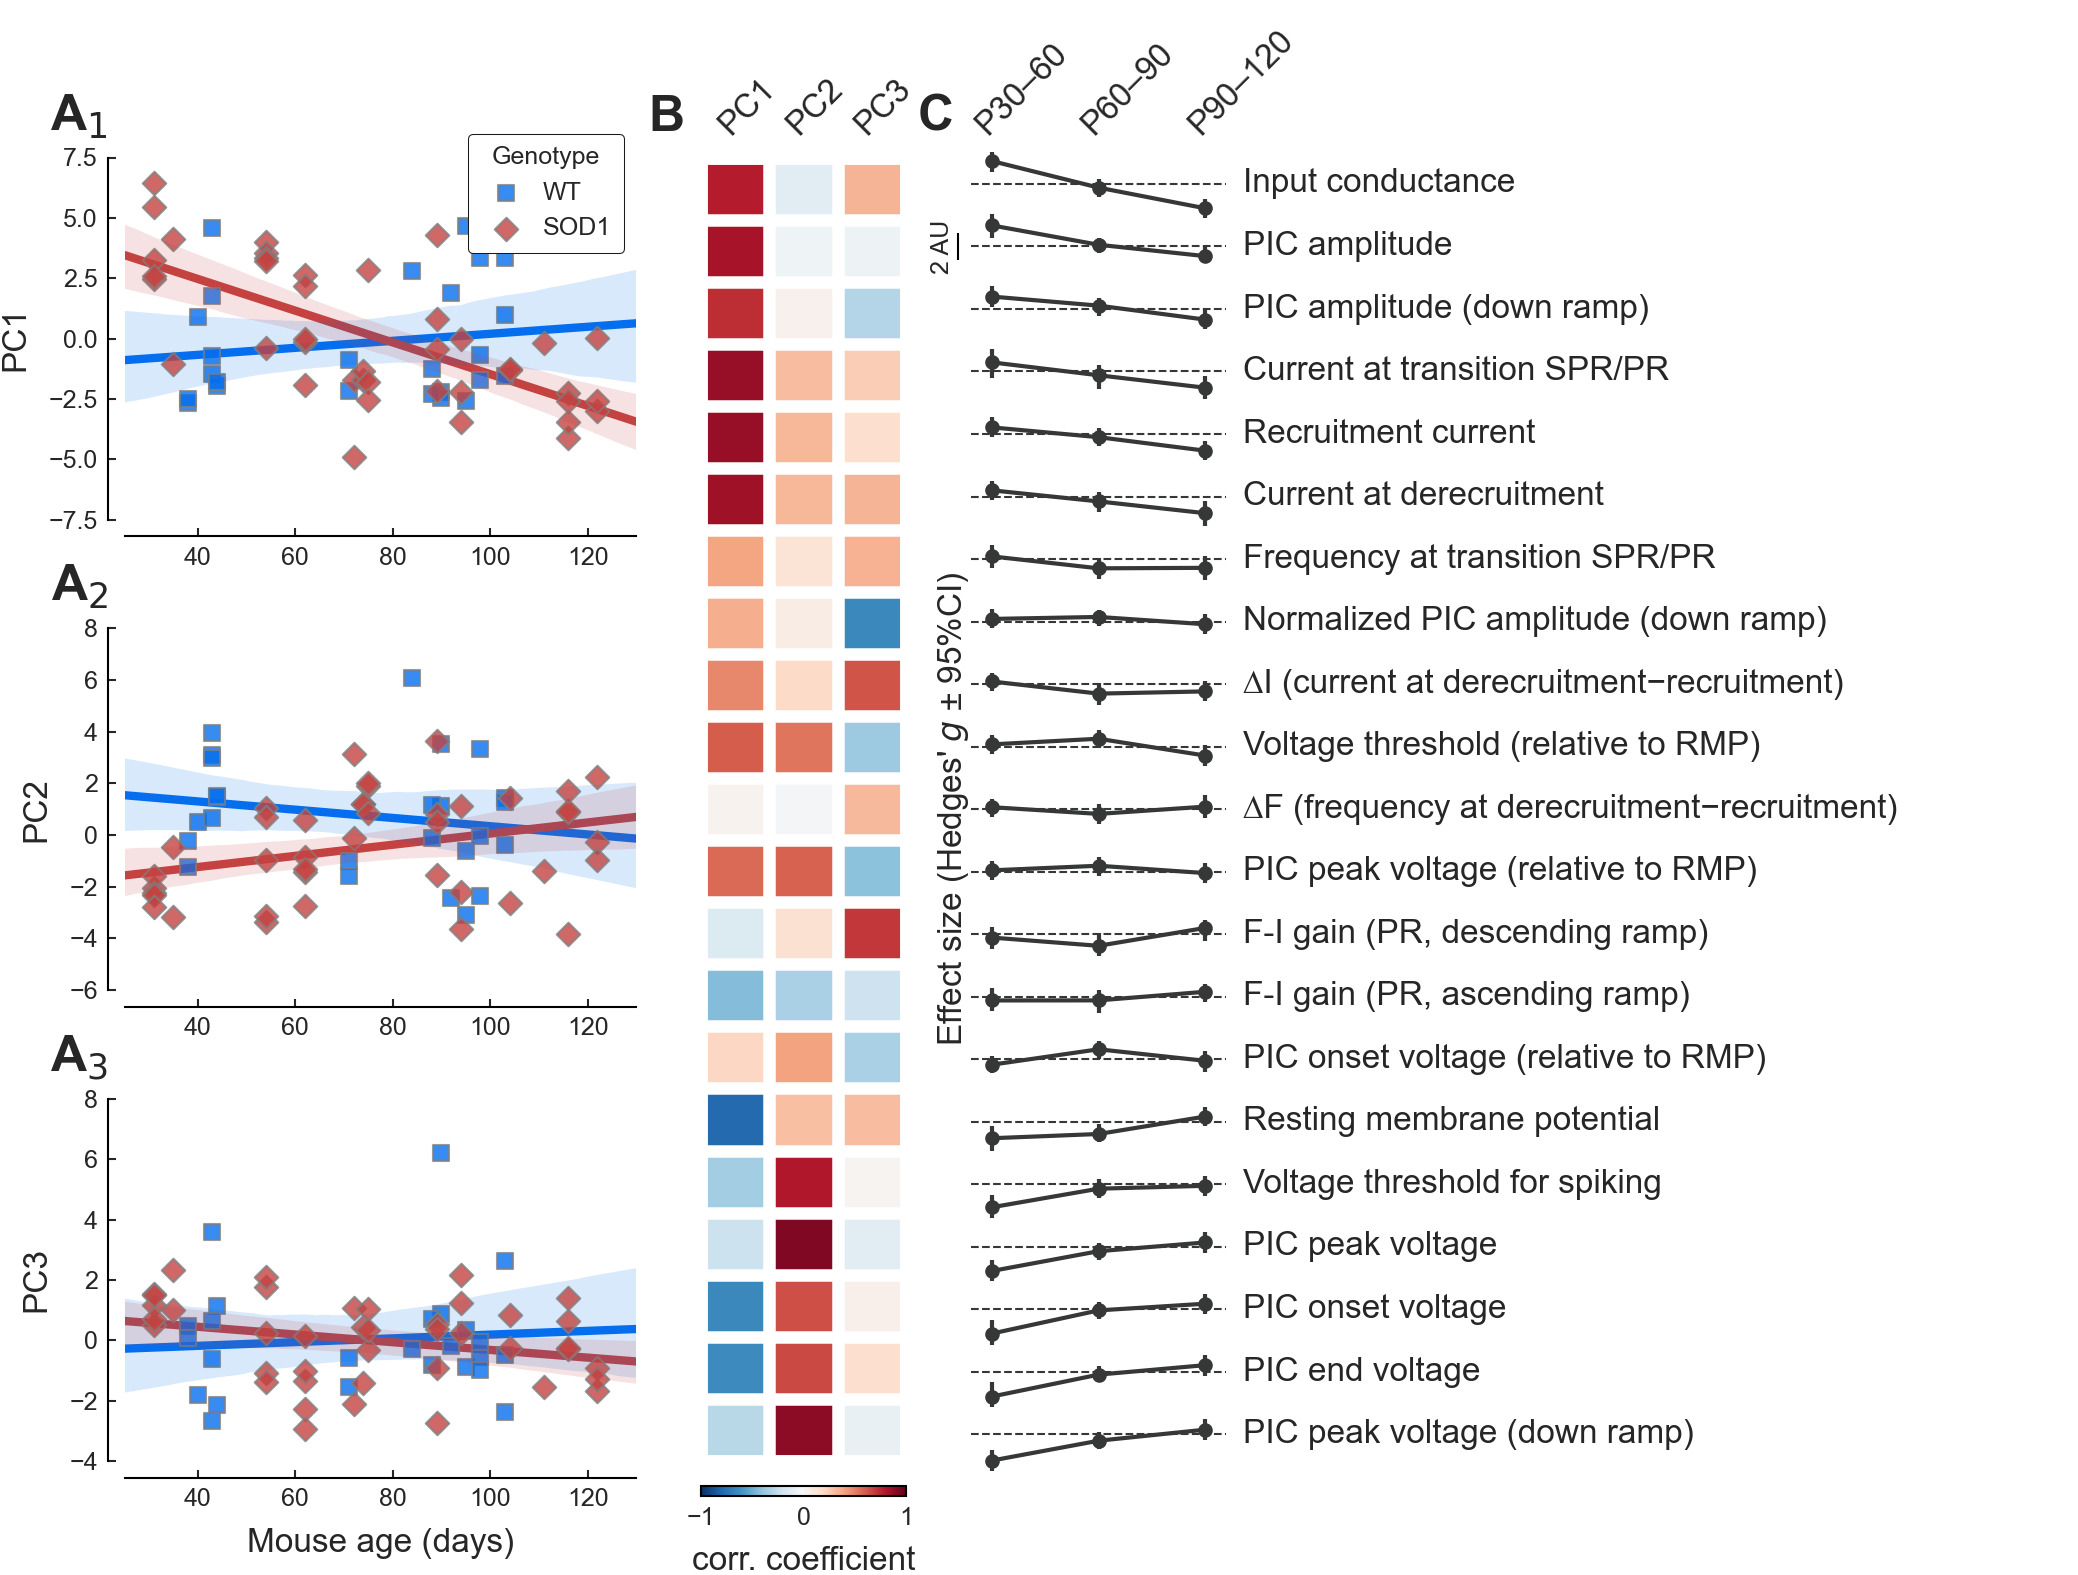

In [94]:
idx = pd.IndexSlice
w = mm2in(176)
h = 0.25

fig = plt.figure(figsize=(w, h*effects.index.size), dpi=300)
gs0 = gridspec.GridSpec(effects.index.size+2, 3, figure=fig, height_ratios=[1]*effects.index.size+[0.1]+[0.2],
                                                             width_ratios=[2,0.8,1])

n_components=3

##
## PCn vs time
##
gs1 = gridspec.GridSpecFromSubplotSpec(n_components,1, subplot_spec=gs0[:-2,0], hspace=0.3)
axs = np.empty(n_components, dtype=object)
for i in range(n_components):
    axs[i] = fig.add_subplot(gs1[i], sharex=axs[0])
    draw_param_vs_time(ax=axs[i], df=data_pca, param=f'PC{i+1}', 
                       label=f'A$_{i+1}$', showLegend=axs[i].is_first_row())
for ax in axs[:-1]:
    ax.set_xlabel('')



##
## Effect size vs. time
##
axs = np.empty(effects.index.size, dtype=object)
for i in range(effects.index.size):
    axs[i] = fig.add_subplot(gs0[i,2], sharex=axs[0], sharey=axs[0])
    axs[i].axis('off')
    axs[i].axhline(0, ls='--', color='xkcd:dark grey')

for (prop,row),ax in zip(effects.loc[:,idx['Hedges\' g',:,:]].iterrows(), axs):
    es = row[idx[:,:,'es']].values
    err = np.abs(np.vstack([row[:,:,'lo'].values,row[:,:,'hi'].values])-es)
    e = ax.errorbar(x=range(len(es)), y=es, yerr=err, fmt='o-', ms=3, lw=1, 
                c='xkcd:dark grey', elinewidth=1, capsize=0, label=prop_labels[prop],
                clip_on=False)
    ax.annotate(prop_labels[prop].replace('\n', ' '), xy=(1,0.5), xycoords='axes fraction', 
                xytext=(4,0), textcoords='offset points',
                va='center', ha='left')
    
    #errorbars are clipped
    for l in e.lines:
        plt.setp(l, clip_on=False)
    
axs[-1].set_xlim(-0.2,2.2)
axs[-1].set_ylim(-2,2)
for i,age in enumerate(ageOrder):
    axs[0].annotate(age, xy=(i,1), xycoords=('data','axes fraction'),
                    xytext=(0,4), textcoords='offset points',
                    va='bottom', ha='left', fontsize=plt.rcParams['axes.labelsize'],
                   rotation=45, rotation_mode='anchor')
axs[0].annotate('C', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')
axs[effects.index.size//2].annotate('Effect size (Hedges\' $g$ ± 95%CI)',
                 xy=(0,0.5), xycoords='axes fraction',
                 xytext=(0,0), textcoords='offset points',
                 fontsize=plt.rcParams['axes.labelsize'], va='bottom', ha='center',
                                   rotation=90, rotation_mode='anchor')

ax=axs[1]
vbar = VSizeBar(ax.transData,
        2,
        "2 AU",
        loc='center right',
        pad=0, borderpad=0, sep=1,
        frameon=False,
        bbox_to_anchor=(-0.05, 0.5),
        bbox_transform=ax.transAxes,textprops=dict(fontsize=6))
ax.add_artist(vbar)
    

    
##
## PC corr. coef
##
corr_data = pca_loadings.reindex(effects.index).iloc[:,:n_components]
from matplotlib.colors import TwoSlopeNorm
cmap = 'RdBu_r'
norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
ax = fig.add_subplot(gs0[:-2,1])
cax = fig.add_subplot(gs0[-1,1])
im = ax.imshow(corr_data, aspect='auto', cmap=cmap, norm=norm, extent=[0,n_components,0,effects.index.size])
fig.colorbar(im, orientation='horizontal', cax=cax, label='corr. coefficient', ticks=[-1,0,1])
for i,l in enumerate(corr_data.columns):
    ax.annotate(l, xy=(i+0.5,1), xycoords=('data','axes fraction'),
                xytext=(0,4), textcoords='offset points',
                    va='bottom', ha='left', fontsize=plt.rcParams['axes.labelsize'],
                   rotation=45, rotation_mode='anchor')
#ax.axis('off')
for s in ax.spines:
    plt.setp(ax.spines[s], visible=True, lw=3, color='white')
ax.set_xticks(np.arange(corr_data.columns.size+1))
ax.set_xticklabels([])
ax.set_yticks(np.arange(corr_data.index.size+1))
ax.set_yticklabels([])
plt.setp(ax.yaxis.get_ticklines(), visible=False)
plt.setp(ax.xaxis.get_ticklines(), visible=False)
ax.grid(True, color='white', linestyle='-', linewidth=3)
ax.annotate('B', xy=(0,1), xytext=(-4,4), xycoords='axes fraction', textcoords='offset points', fontfamily='Arial', fontsize=12, fontweight='bold', va='bottom', ha='right')

###
### adjust figure subplots
###
#fig.set_facecolor('grey')
fig.subplots_adjust(top=0.9, bottom=0.05, left=0.06, right=0.59)
###
###
###
plt.savefig('./Figure 7.png')
plt.savefig('./Figure 7.tiff', dpi=600)
plt.savefig('./Figure 7.pdf')
plt.show()

## Figure 8

In [95]:
params = ['Gin', 'PIC Amp', 'V_PIC onset', 'RMP']
timePoints = ['E17.5','P0–5','P6–12','P30–60','P60–90','P90–120']
x_vals = [-5, 2.5, 9, 45, 75, 105]

create a dataframe with the values of hedges' *g* and 95%CI for each time point and each parameter

In [96]:
evol_df = pd.DataFrame(columns=pd.MultiIndex.from_product([timePoints,['g','ci']]), index=params, dtype=float)
# populate with the data from this study
for prop in params:
    temp = pd.DataFrame(columns=['g','ci'], index=['P30–60','P60–90','P90–120'])
    temp['g'] = hedges_gs[prop].statistical_tests['difference'].tolist()
    temp['ci'] = hedges_gs[prop].statistical_tests[['difference','bca_high']].diff(axis=1).iloc[:,-1].tolist()
    evol_df.loc[prop] = temp.stack()

E17.5 data are from Martin E, Cazenave W, Cattaert D, Branchereau P (2013) Embryonic alteration of motoneuronal morphology induces hyperexcitability in the mouse model of amyotrophic lateral sclerosis. Neurobiology of disease 54:116–126.

Effect size for $G_{in}$ is calculated from the p-value since the values are provided as *R_{in}$

P0–5 and P6–12 data are from Quinlan, K. A.; Schuster, J. E.; Fu, R.; Siddique, T.; Heckman, C. J. Altered Postnatal Maturation of Electrical Properties in Spinal Motoneurons in a Mouse Model of Amyotrophic Lateral Sclerosis. The Journal of Physiology 2011, 589 (Pt 9), 2245–2260.

In [97]:
data_Martin_txt = """	E17.5	E17.5
	g	ci
Gin	0.9536	0.73875
PIC Amp		
V_PIC onset		
RMP	-0.2434	0.71195
"""
temp = pd.read_csv(StringIO(data_Martin_txt), sep='\t', index_col=0, header=[0,1])
evol_df['E17.5'] = temp['E17.5']

In [98]:
data_Quinlan_txt = """
P0–5	P0–5	P6–12	P6–12
g	ci	g	ci
Gin	0.47283915573858193	0.5539094040548855	0.4843948929275647	0.49918247003312594
PIC Amp	1.0718056524203396	0.7531457347705782	0.8434878612474501	0.6349896646307589
V_PIC onset	0.0	0.7026213441015631	-0.32471256673663484	0.6116454401905217
RMP	0.24427480916030533	0.7026213441015631	0.0	0.6116454401905217
"""
temp = pd.read_csv(StringIO(data_Quinlan_txt), sep='\t', header=[0,1])
evol_df['P0–5'] = temp['P0–5']
evol_df['P6–12'] = temp['P6–12']

In [99]:
evol_df

E17.5               P0–5               P6–12            \
                  g       ci         g        ci         g        ci   
Gin          0.9536  0.73875  0.472839  0.553909  0.484395  0.499182   
PIC Amp         NaN      NaN  1.071806  0.753146  0.843488  0.634990   
V_PIC onset     NaN      NaN  0.000000  0.702621 -0.324713  0.611645   
RMP         -0.2434  0.71195  0.244275  0.702621  0.000000  0.611645   

               P30–60              P60–90             P90–120            
                    g        ci         g        ci         g        ci  
Gin          1.729220  0.666413 -0.283289  0.672120 -1.850730  0.683687  
PIC Amp      1.592659  0.882355  0.124986  0.543573 -0.735718  0.736129  
V_PIC onset -1.827803  1.016302 -0.072711  0.609805  0.433860  0.733747  
RMP         -1.241359  0.958021 -0.922005  0.736688  0.401405  0.698627

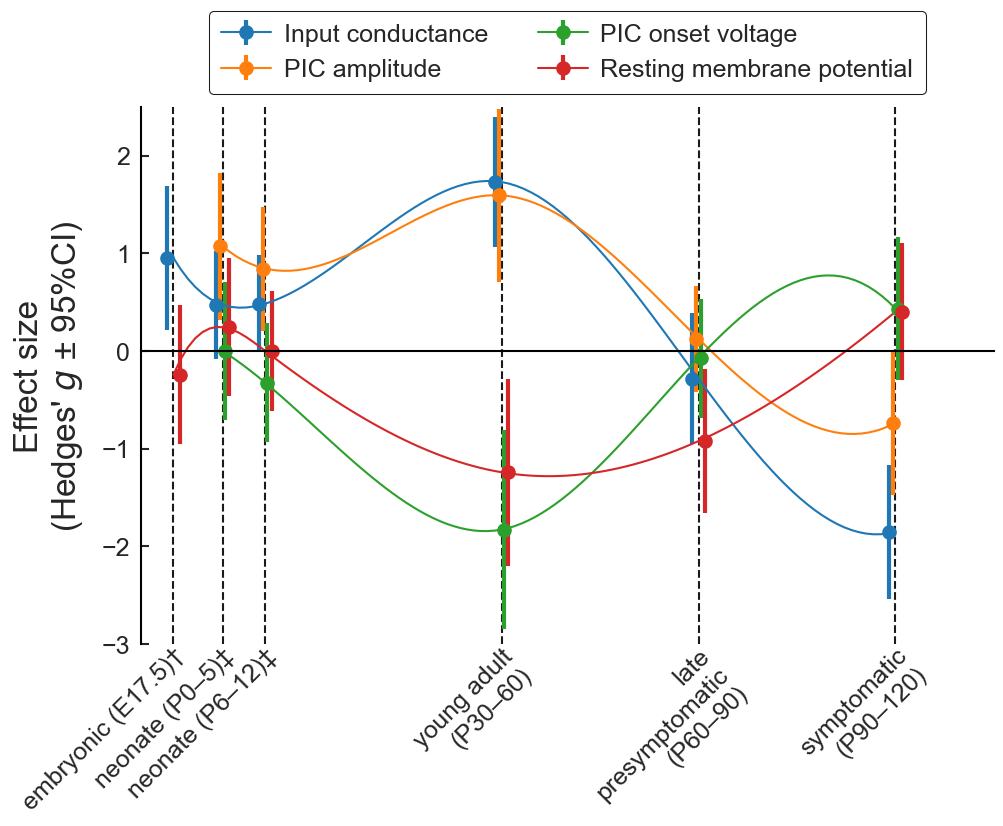

In [100]:
from scipy import interpolate

fig,ax = plt.subplots(figsize=(mm2in(85),mm2in(70)), dpi=300)
cycler = itertools.cycle(plt.rcParams['axes.prop_cycle']) # color iterator
idx = pd.IndexSlice

#x_temp is used to jitter a bit the values on the x axis so that the CI do not overlap
for p,x_temp in zip(params, np.linspace(-1,1,len(params))): 
    c = next(cycler)['color']
    x_temp = x_vals + x_temp
    y = evol_df.loc[p,idx[:,'g']].values
    label = prop_labels[p].replace('\n',' ')
    ax.errorbar(x_temp, y, yerr=evol_df.loc[p,idx[:,'ci']].values, fmt='o', color=c, clip_on=False, lw=1, label=label, ms=3)
    
    # embryonic time point is missing some values, the lines below is to ensure the cubic spline interpolation works and that
    # we are only fitting over the range where we have data
    temp_x_vals = np.array(x_vals)[~pd.isna(y)]
    temp_y = y[~pd.isna(y)]
    xnew = np.linspace(temp_x_vals.min(), temp_x_vals.max(), 100)
    tck = interpolate.splrep(temp_x_vals, temp_y, s=0)
    ynew = interpolate.splev(xnew, tck, der=0)
    ax.plot(xnew, ynew, '-', color=c, clip_on=False, label=label)

# this is a trick to combine the points+line in the legend
h,l = ax.get_legend_handles_labels()
h = [(h[i],h[i+len(params)]) for i in range(len(params))]
ax.legend(h,l, 
          bbox_to_anchor=(0.5,1), loc='lower center',
          ncol=2)

# other prettyfications
ax.set_ylabel('Effect size\n(Hedges\' $g$ ± 95%CI)')
ax.set_xlim(-10,120)
ax.set_xticks([])
ax.set_ylim(-3,2.5)
ax.spines['bottom'].set_position('zero')
sns.despine(ax=ax)
#
for x,label in zip(x_vals, ['embryonic (E17.5)†','neonate (P0–5)‡', 'neonate (P6–12)‡',
                                'young adult\n(P30–60)',
                                'late\npresymptomatic\n(P60–90)',
                                'symptomatic\n(P90–120)']):
    ax.axvline(x, ls='--', color='k', lw=0.5, zorder=0)
    ax.annotate(label, xy=(x,0), xycoords=('data','axes fraction'), xytext=(0,0), textcoords='offset points', rotation=45, ha="right", va='top', rotation_mode="anchor", fontsize=6)

fig.subplots_adjust(left=0.14, right=0.99, top=0.87, bottom=0.22)
#fig.set_facecolor('grey')
plt.savefig('./Figure 8.png')
plt.savefig('./Figure 8.tiff', dpi=600)
plt.savefig('./Figure 8.pdf')
plt.show()

# Table

In [101]:
effects

effect_size    Hedges' g                                                    \
AgeGroup          P30–60                        P60–90                       
                      es        lo        hi        es        lo        hi   
prop                                                                         
Gin             1.729220  0.929597  2.395633 -0.283289 -0.957662  0.388832   
PIC Amp         1.592659  0.622757  2.475014  0.124986 -0.525093  0.668559   
PICdown Amp     0.937128  0.153642  1.704153  0.251659 -0.498272  0.819419   
I_SPR-PR        0.689803 -0.480829  1.677877 -0.287239 -1.336393  0.480836   
Ion             0.501863 -0.251791  1.260805 -0.240467 -0.938222  0.431055   
Ioff            0.469847 -0.237797  1.188852 -0.368620 -1.164356  0.332393   
F_SPR-PR        0.202496 -0.653274  1.039037 -0.701490 -1.521798  0.085083   
PICdown/Gin     0.202435 -0.477558  0.958413  0.352481 -0.352684  0.889381   
∆I              0.199740 -0.494047  0.871409 -0.719631 -1.566113  0.050011   
∆Vth            0.173742 -0.531083  0.864632  0.600661 -0.127465  1.262423   
∆F              0.150835 -0.557353  0.804327 -0.356988 -1.123382  0.369576   
∆V_PIC peak     0.104910 -0.614874  0.819235  0.453393 -0.341695  1.100809   
Gain_Desc      -0.253026 -1.149012  0.578829 -0.876258 -1.685116  0.105631   
Gain_Asc       -0.277797 -1.091857  0.632837 -0.272838 -1.232782  0.526542   
∆V_PIC onset   -0.407232 -1.049463  0.280576  0.759163  0.013452  1.398406   
RMP            -1.241359 -2.191834 -0.283337 -0.922005 -1.541925 -0.185317   
Vth            -1.735133 -2.529510 -0.837386 -0.327609 -1.035608  0.377158   
V_PIC peak     -1.825511 -2.596092 -1.027767 -0.325358 -0.967503  0.327762   
V_PIC onset    -1.827803 -2.685582 -0.811501 -0.072711 -0.702853  0.537094   
V_PIC offset   -1.863433 -2.685953 -0.796114 -0.201019 -0.768800  0.424112   
V_PICdown peak -1.973553 -2.784212 -1.165524 -0.471809 -1.076443  0.155884   

effect_size                                  mean difference             \
AgeGroup         P90–120                              P30–60              
                      es        lo        hi              es         lo   
prop                                                                      
Gin            -1.850730 -2.569251 -1.167043        0.303439   0.192912   
PIC Amp        -0.735718 -1.265832  0.000411        4.426667   2.560351   
PICdown Amp    -0.807794 -1.494275 -0.026261        2.899930   0.859123   
I_SPR-PR       -1.230853 -2.072639 -0.346974        2.075952  -0.946032   
Ion            -1.263780 -1.955491 -0.523516        1.488554  -0.650000   
Ioff           -1.261374 -2.227269 -0.371703        1.722957  -0.730050   
F_SPR-PR       -0.665126 -1.581346  0.226145        3.602857 -10.881429   
PICdown/Gin    -0.200131 -0.917093  0.601210        1.126424  -2.417527   
∆I             -0.551220 -1.282784  0.271192        0.250568  -0.535338   
∆Vth           -0.674943 -1.440760  0.152111        1.052936  -3.066992   
∆F              0.193668 -0.664588  1.043521        1.981988  -5.934211   
∆V_PIC peak    -0.102775 -0.867612  0.664671        0.813193  -4.992526   
Gain_Desc       0.478726 -0.481876  1.069998       -1.981433 -12.037473   
Gain_Asc        0.379560 -0.413043  0.940355       -0.995435  -3.679135   
∆V_PIC onset   -0.113265 -0.928837  0.644395       -2.310316  -6.234351   
RMP             0.401405 -0.324823  1.100032       -9.070035 -13.371228   
Vth            -0.109662 -0.846081  0.627184       -9.507289 -12.794737   
V_PIC peak      0.336553 -0.425346  1.145794       -8.493684 -11.411228   
V_PIC onset     0.433860 -0.352066  1.167607      -11.380351 -14.952281   
V_PIC offset    0.516070 -0.276882  1.268190      -12.692982 -16.677193   
V_PICdown peak  0.365740 -0.408028  1.197975       -9.901404 -13.104561   

effect_size                                                          \
AgeGroup                      P60–90                        P90–120   
                       hi      

In [102]:
def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)+1):
        yield chr(c)

from dabest._bootstrap_tools import bootstrap
import xlsxwriter
workbook = xlsxwriter.Workbook('Table 1.xlsx')
worksheet = workbook.add_worksheet()

wrap = workbook.add_format({'text_wrap': True, 'valign':'vcenter'})
align_right = workbook.add_format({'align': 'right', 'valign':'vcenter'})
align_center = workbook.add_format({'align': 'center', 'valign':'vcenter'})
align_left = workbook.add_format({'align': 'left', 'valign':'vcenter'})
wrap_center = workbook.add_format({'text_wrap': True, 'align':'center', 'valign':'vcenter'})
row_header = workbook.add_format({'text_wrap': True, 'align':'right', 'valign':'vcenter'})
age_format = workbook.add_format({'align':'center', 'bottom':1, 'font_size':14, 'bold':True, 'valign':'bottom'})
header_format = workbook.add_format({'align':'center', 'bottom':2, 'bold':True, 'valign':'bottom', 'text_wrap':True})
img_format = workbook.add_format({'align':'center', 'valign':'bottom'})
bottom_format = workbook.add_format({'top':6})

N_per_age=5
row = 0
for i,age in enumerate(ageOrder):
    worksheet.merge_range(row,2+i*N_per_age,row,2+i*N_per_age+3,age, age_format)
row+=1
worksheet.write(row,0,'',header_format)
worksheet.write(row,1,'',header_format)
for i,age in enumerate(ageOrder):
    for j,(g,n) in enumerate(zip(genotypeOrder,
                                 mean_diffs[list(mean_diffs)[0]].statistical_tests.iloc[i,2:4])):
        worksheet.write(row,2+i*N_per_age+j,f'{g}\n(N={n})', header_format)
    worksheet.write(row,2+i*N_per_age+2,'Mean diff.', header_format)
    worksheet.write(row,2+i*N_per_age+3,'Hedges\' g', header_format)
    worksheet.write(row,2+i*N_per_age+4,'', header_format)
row+=1
worksheet.write(row-1,0,'',row_header)
for k,prop in enumerate(effects.index):
    worksheet.write(row,0, f'{prop_labels[prop]}', row_header)
    for i,age in enumerate(ageOrder):
        for j,g in enumerate(genotypeOrder):
            print(prop,age,g)
            temp = data.loc[(data['Genotype']==g)&(data['AgeGroup']==age), prop]
            boot = bootstrap(temp.dropna().values)
            m,s = temp.apply(['mean','std'])
            out = f'{m:.2f} ± {s:.2f} {prop_units[prop]}\n[{boot.bca_ci_low:.2f}–{boot.bca_ci_high:.2f}]'
            out = out.replace('-','−')
            worksheet.write(row, 2+i*N_per_age+j, out, wrap_center)
        
        temp = mean_diffs[prop].statistical_tests.iloc[i]
        p = temp["pvalue_welch"]
        if p<0.05:
            p_text = f'(p={p:.2g} {stars(p)})'
        else:
            p_text = f'(p={p:.2g})'
        out = f'{temp["difference"]:.2f} {prop_units[prop]} [{temp["bca_low"]:.2f}—{temp["bca_high"]:.2f}]\n{p_text}'
        out = out.replace('-','−')
        worksheet.write(row, 2+i*N_per_age+2, out, wrap_center)
        
        temp = hedges_gs[prop].statistical_tests.iloc[i]
        out = f'{temp["difference"]:.2f}\n[{temp["bca_low"]:.2f}—{temp["bca_high"]:.2f}]'
        out = out.replace('-','−')
        worksheet.write(row, 2+i*N_per_age+3, out, wrap_center)
    row+=1
for c in range(0,len(ageOrder)*N_per_age+2):
    worksheet.write(row,c,'',bottom_format)

worksheet.set_column('A:A', 25)
width = 17
pad = 3
    
for col in char_range('B','Q'):
    w = width
    if col in ['B','G','L','Q']:
        w = pad
    if col in ['E','J','O']:
        w *= 1.5
    worksheet.set_column(f'{col}:{col}', w)

for row in range(0,effects.index.size+3):
    worksheet.set_row(row, 36)

worksheet.set_landscape()
worksheet.hide_gridlines()
worksheet.fit_to_pages(1, 1)

workbook.close()

Gin P30–60 WT
Gin P30–60 SOD1
Gin P60–90 WT
Gin P60–90 SOD1
Gin P90–120 WT
Gin P90–120 SOD1
PIC Amp P30–60 WT
PIC Amp P30–60 SOD1
PIC Amp P60–90 WT
PIC Amp P60–90 SOD1
PIC Amp P90–120 WT
PIC Amp P90–120 SOD1
PICdown Amp P30–60 WT
PICdown Amp P30–60 SOD1
PICdown Amp P60–90 WT
PICdown Amp P60–90 SOD1
PICdown Amp P90–120 WT
PICdown Amp P90–120 SOD1
I_SPR-PR P30–60 WT
I_SPR-PR P30–60 SOD1
I_SPR-PR P60–90 WT
I_SPR-PR P60–90 SOD1
I_SPR-PR P90–120 WT
I_SPR-PR P90–120 SOD1
Ion P30–60 WT
Ion P30–60 SOD1
Ion P60–90 WT
Ion P60–90 SOD1
Ion P90–120 WT
Ion P90–120 SOD1
Ioff P30–60 WT
Ioff P30–60 SOD1
Ioff P60–90 WT
Ioff P60–90 SOD1
Ioff P90–120 WT
Ioff P90–120 SOD1
F_SPR-PR P30–60 WT
F_SPR-PR P30–60 SOD1
F_SPR-PR P60–90 WT
F_SPR-PR P60–90 SOD1
F_SPR-PR P90–120 WT
F_SPR-PR P90–120 SOD1
PICdown/Gin P30–60 WT
PICdown/Gin P30–60 SOD1
PICdown/Gin P60–90 WT
PICdown/Gin P60–90 SOD1
PICdown/Gin P90–120 WT
PICdown/Gin P90–120 SOD1
∆I P30–60 WT
∆I P30–60 SOD1
∆I P60–90 WT
∆I P60–90 SOD1
∆I P90–120 WT
∆I P90–1